In [2]:
import numpy as np
import pandas as pd
import time as time
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import norm, t
from scipy.optimize import brentq
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

In [ ]:
data = pd.read_csv('feds200628.csv', header=7)

data = data.set_index('Date')
data.index = pd.to_datetime(data.index)

one_year_forward_cols = ['SVEN1F01', 'SVEN1F04', 'SVEN1F09']
instant_forward_cols = ['SVENF01', 'SVENF02', 'SVENF03', 'SVENF04', 'SVENF05', 'SVENF06',
       'SVENF07', 'SVENF08', 'SVENF09', 'SVENF10', 'SVENF11', 'SVENF12',
       'SVENF13', 'SVENF14', 'SVENF15', 'SVENF16', 'SVENF17', 'SVENF18',
       'SVENF19', 'SVENF20', 'SVENF21', 'SVENF22', 'SVENF23', 'SVENF24',
       'SVENF25', 'SVENF26', 'SVENF27', 'SVENF28', 'SVENF29', 'SVENF30']
par_cols = ['SVENPY01', 'SVENPY02', 'SVENPY03', 'SVENPY04', 'SVENPY05', 'SVENPY06',
       'SVENPY07', 'SVENPY08', 'SVENPY09', 'SVENPY10', 'SVENPY11', 'SVENPY12',
       'SVENPY13', 'SVENPY14', 'SVENPY15', 'SVENPY16', 'SVENPY17', 'SVENPY18',
       'SVENPY19', 'SVENPY20', 'SVENPY21', 'SVENPY22', 'SVENPY23', 'SVENPY24',
       'SVENPY25', 'SVENPY26', 'SVENPY27', 'SVENPY28', 'SVENPY29', 'SVENPY30']
zero_cols = ['SVENY01', 'SVENY02', 'SVENY03', 'SVENY04', 'SVENY05', 'SVENY06',
       'SVENY07', 'SVENY08', 'SVENY09', 'SVENY10', 'SVENY11', 'SVENY12',
       'SVENY13', 'SVENY14', 'SVENY15', 'SVENY16', 'SVENY17', 'SVENY18',
       'SVENY19', 'SVENY20', 'SVENY21', 'SVENY22', 'SVENY23', 'SVENY24',
       'SVENY25', 'SVENY26', 'SVENY27', 'SVENY28', 'SVENY29', 'SVENY30']
param_cols = ['BETA0', 'BETA1', 'BETA2', 'BETA3', 'TAU1', 'TAU2']

In [ ]:
#Compute zero coupon bond pricces from yields
zero_coupon_yield = data[zero_cols]
zero_coupon_yield.columns = [int(col.split('Y')[1]) for col in zero_coupon_yield.columns]
zero_coupon_yield = zero_coupon_yield.dropna(how='all')
zero_bond_prices = np.exp(-zero_coupon_yield*zero_coupon_yield.columns/100)
display(zero_bond_prices)

one_year_zero_bond = zero_bond_prices[1]

def interpolate_zero_bond_prices(time_index, maturity):
    if maturity <= 1:
        return maturity*one_year_zero_bond.iat[time_index] + 1 - maturity
    else:
        index = int(maturity)-1
        w = maturity-index-1
        if w == 0:
            return zero_bond_prices.iat[time_index, index]
        else:
            return w*zero_bond_prices.iat[time_index, index+1] + (1-w)*zero_bond_prices.iat[time_index, index]

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Date,,,,,,,,,,,,,,,,,,,,,
1961-06-14,0.970615,0.934688,0.898894,0.864369,0.831158,0.799230,0.768524,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-15,0.970503,0.934005,0.897679,0.862673,0.829025,0.796688,0.765613,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-16,0.970434,0.933995,0.897644,0.862593,0.828901,0.796521,0.765410,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-19,0.970495,0.933540,0.896949,0.861745,0.827919,0.795422,0.764200,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-20,0.970608,0.934072,0.897665,0.862597,0.828892,0.796502,0.765378,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-14,0.958497,0.918766,0.880412,0.843179,0.806913,0.771544,0.737053,0.703455,0.670781,0.639096,...,0.365884,0.348036,0.331245,0.315474,0.300675,0.286795,0.273794,0.261627,0.250241,0.239587
2025-02-18,0.958274,0.918038,0.879035,0.841101,0.804154,0.768158,0.733117,0.699056,0.666023,0.634048,...,0.360515,0.342687,0.325902,0.310129,0.295319,0.281417,0.268385,0.256176,0.244737,0.234031
2025-02-19,0.958436,0.918505,0.879839,0.842212,0.805494,0.769639,0.734648,0.700562,0.667427,0.635305,...,0.360583,0.342845,0.326187,0.310568,0.295932,0.282231,0.269423,0.257448,0.246267,0.235814


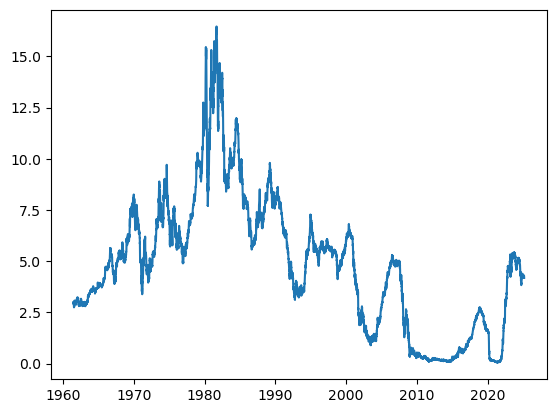

In [5]:
plt.plot(zero_coupon_yield[1]);

In [6]:
shifted_dates = pd.DataFrame()
shifted_dates['1_day_shifted_date'] = np.concatenate((zero_bond_prices.index[1:], zero_bond_prices.index[[-1]]))
for tenor in [1, 2, 3, 5, 7, 10, 15, 20, 30]:
    shifted_dates[f'{tenor}_year_shifted_date'] = [zero_bond_prices.index[zero_bond_prices.index <= zero_bond_prices.index[i] + pd.offsets.DateOffset(years=tenor)][-1] 
                                                   if zero_bond_prices.index[i] + pd.offsets.DateOffset(years=tenor) <= pd.Timestamp(year=2025, month=2, day=21)
                                                   else np.nan for i in range(len(zero_bond_prices))]
shifted_dates.index = zero_bond_prices.index[:len(shifted_dates)]

In [7]:
shifted_dates

,1_day_shifted_date,1_year_shifted_date,2_year_shifted_date,3_year_shifted_date,5_year_shifted_date,7_year_shifted_date,10_year_shifted_date,15_year_shifted_date,20_year_shifted_date,30_year_shifted_date
Date,,,,,,,,,,
1961-06-14,1961-06-15,1962-06-14,1963-06-14,1964-06-12,1966-06-14,1968-06-14,1971-06-14,1976-06-14,1981-06-12,1991-06-14
1961-06-15,1961-06-16,1962-06-15,1963-06-14,1964-06-15,1966-06-15,1968-06-14,1971-06-15,1976-06-15,1981-06-15,1991-06-14
1961-06-16,1961-06-19,1962-06-15,1963-06-14,1964-06-16,1966-06-16,1968-06-14,1971-06-16,1976-06-16,1981-06-16,1991-06-14
1961-06-19,1961-06-20,1962-06-19,1963-06-19,1964-06-19,1966-06-17,1968-06-19,1971-06-18,1976-06-18,1981-06-19,1991-06-19
1961-06-20,1961-06-21,1962-06-20,1963-06-20,1964-06-19,1966-06-20,1968-06-20,1971-06-18,1976-06-18,1981-06-19,1991-06-20
...,...,...,...,...,...,...,...,...,...,...
2025-02-14,2025-02-18,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2025-02-18,2025-02-19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2025-02-19,2025-02-20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [ ]:
#Compute overnight rates
days_diff = np.array([elem.days for elem in zero_bond_prices.index[1:]-zero_bond_prices.index[:-1]])
overnight_ratio = 1/((days_diff/365)*zero_bond_prices[1][:-1] + ((365-days_diff)/365))
overnight_ratio

Date
1961-06-14    1.000081
1961-06-15    1.000081
1961-06-16    1.000243
1961-06-19    1.000081
1961-06-20    1.000081
                ...   
2025-02-13    1.000115
2025-02-14    1.000455
2025-02-18    1.000114
2025-02-19    1.000114
2025-02-20    1.000114
Name: 1, Length: 15885, dtype: float64

In [ ]:
#Naive strategy
short_shifted_date = shifted_dates['1_year_shifted_date']
def get_term_strategy_return(tenor):
    long_shifted_date = shifted_dates[f'{tenor}_year_shifted_date'].dropna()
    terminal_short_units = []
    excess_returns = []
    ts = []
    for i in range(len(long_shifted_date)):
    
        start = long_shifted_date.index[i]
        current = start
        end = long_shifted_date.iat[i]
        if end is pd.NaT or np.isnan(zero_bond_prices.at[start, tenor]):
            continue
        short_units = zero_bond_prices.at[start, tenor]/zero_bond_prices.at[start, 1]
        
        for i in range(tenor-1):
            current = short_shifted_date.at[current]
            short_units /= zero_bond_prices.at[current, 1]
            
        terminal_short_units.append(short_units)
        excess_returns.append((1-short_units)/zero_bond_prices.at[start, tenor])
        ts.append(start)
       
    excess_returns = (1+np.array(excess_returns))**(1/tenor) - 1
    return ts, excess_returns

In [10]:
tenors = [2, 3, 5, 7, 10, 15, 20, 30]
ts, excess_returns = [], []
for i, tenor in enumerate(tenors):
    t, returns = get_term_strategy_return(tenor)
    ts.append(t)
    excess_returns.append(returns)

C:\Users\User\AppData\Local\Temp\ipykernel_1828\2317873498.py:26: RuntimeWarning: invalid value encountered in power
  excess_returns = (1+np.array(excess_returns))**(1/tenor) - 1


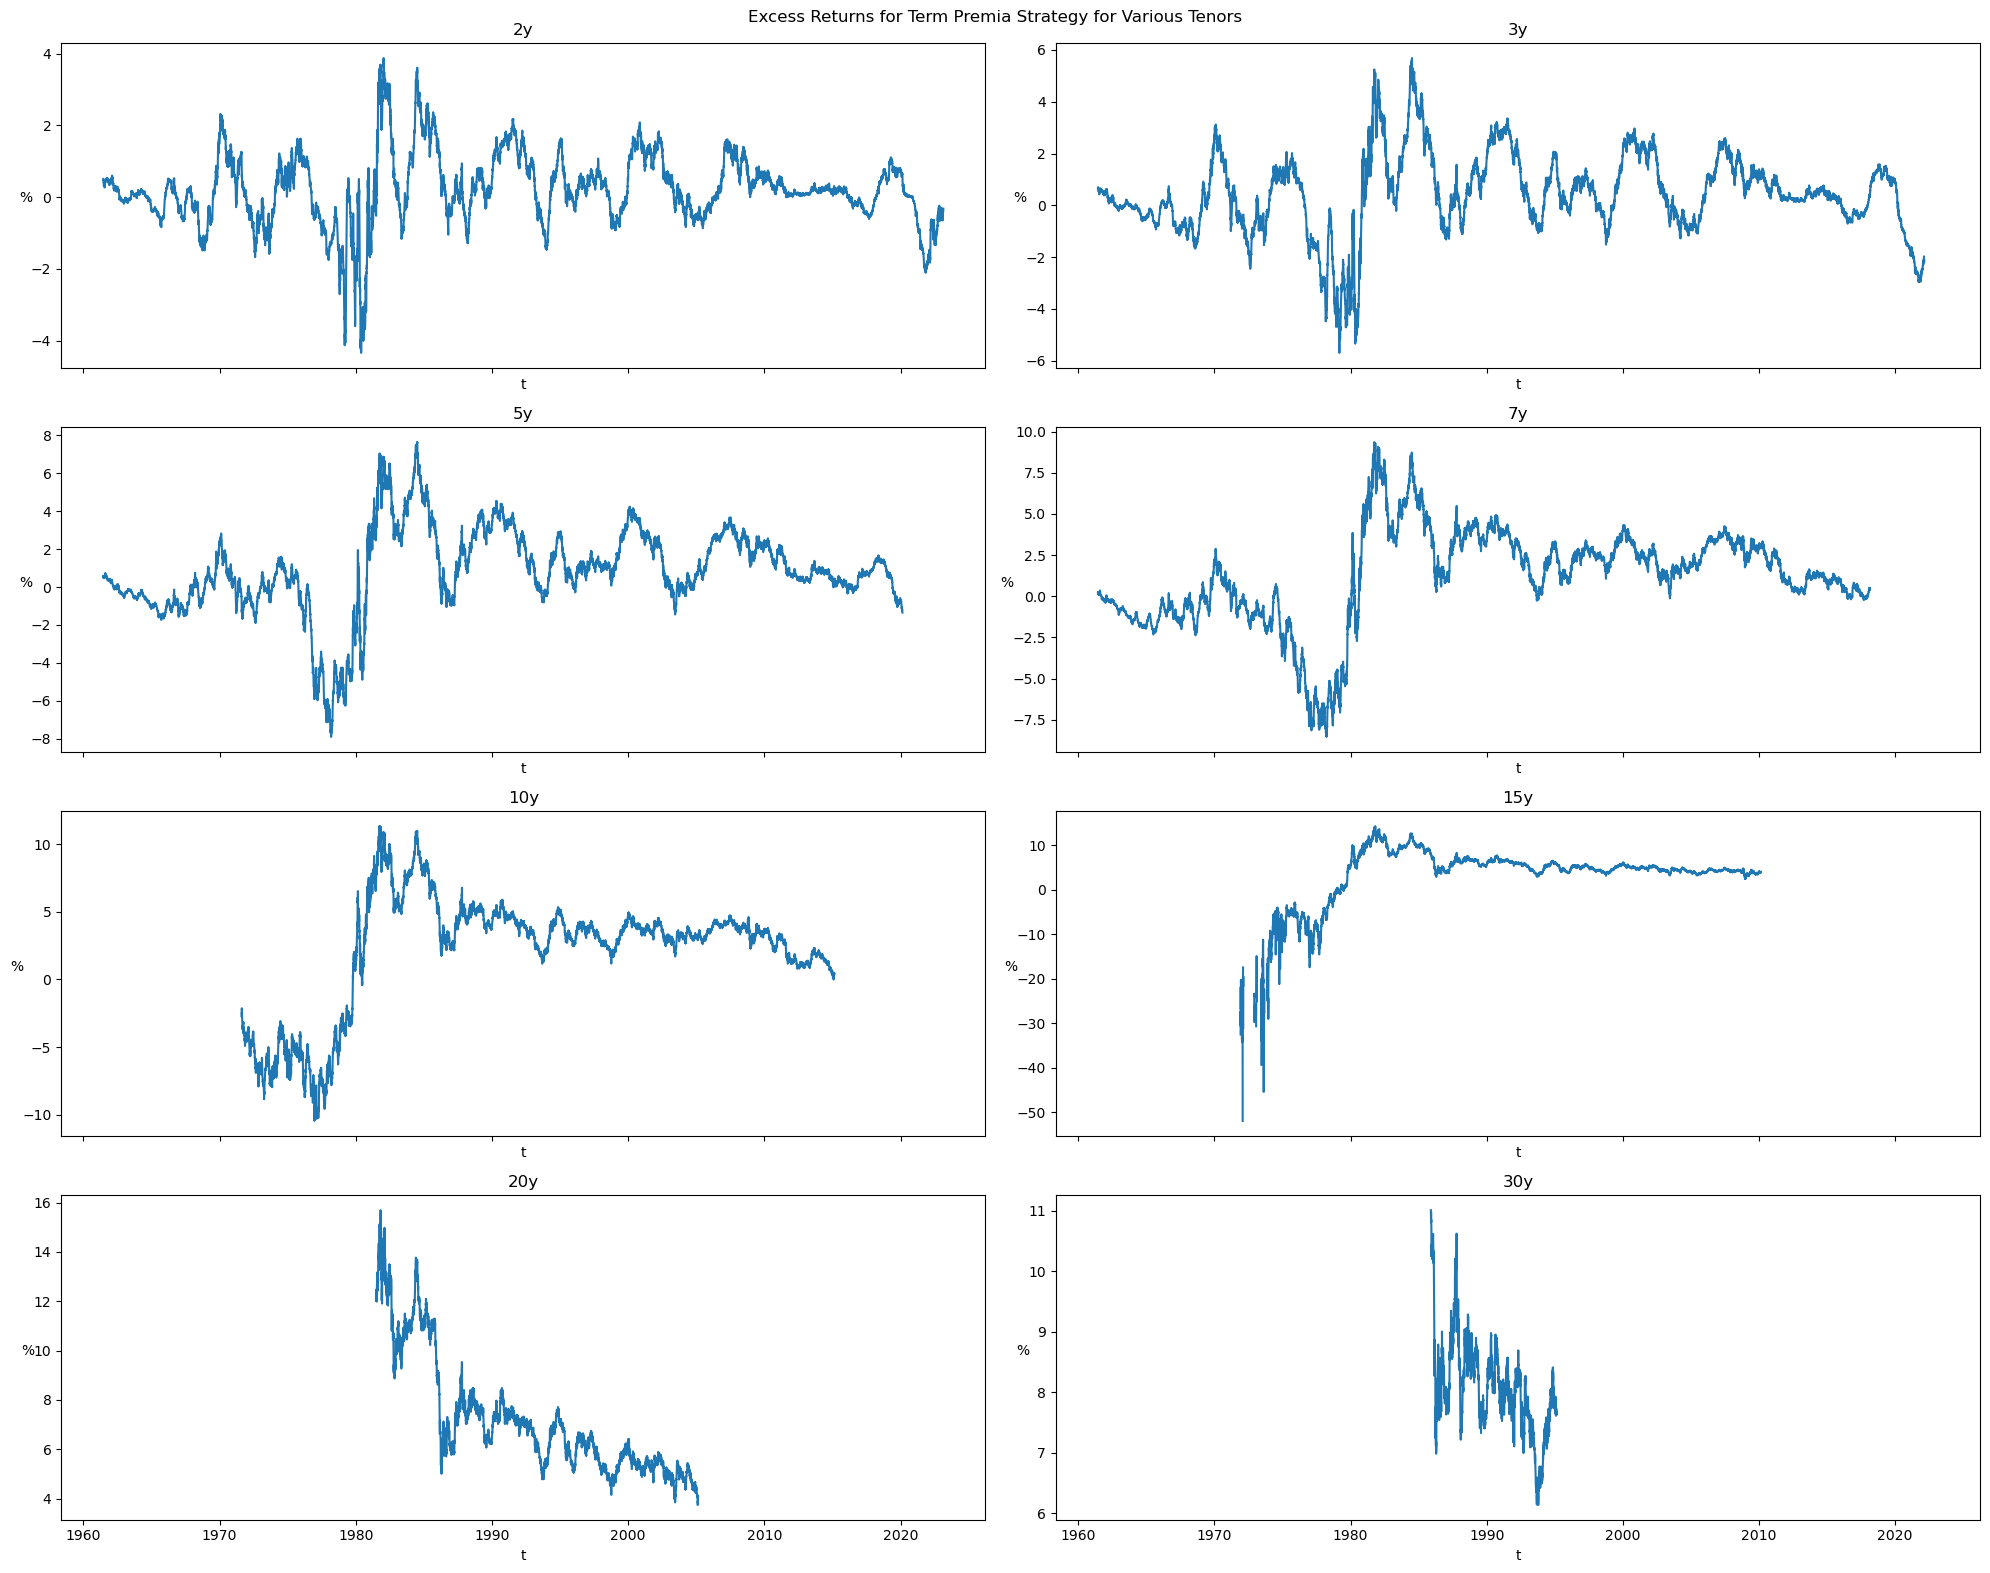

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 16), sharex='all')
fig.suptitle('Excess Returns for Term Premia Strategy for Various Tenors')
for i, tenor in enumerate(tenors):
    axs[i//2][i%2].plot(ts[i], 100*excess_returns[i])
    axs[i//2][i%2].set_title(f'{tenor}y')
    axs[i//2][i%2].set_ylabel('%', rotation=0)
    axs[i//2][i%2].set_xlabel('t')
plt.tight_layout()

Estimating price evolution of a particular zero-bond to track PnL and margin requirements
Assumptions:
- Interpolation
- Day convention

Text(0, 0.5, 'Price')

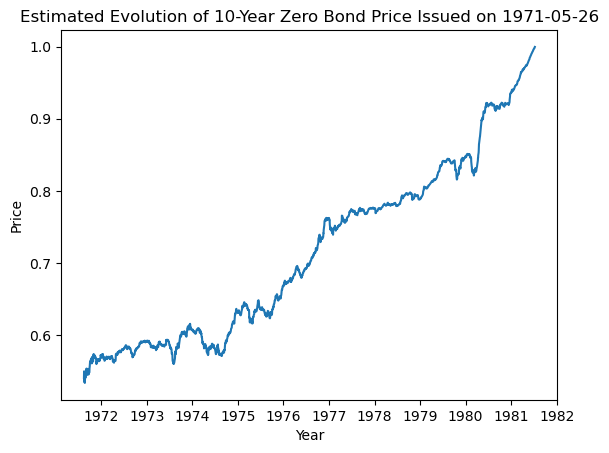

In [12]:
date_index = 5000
mat = 10
plt.plot(zero_bond_prices.iloc[date_index-mat*252:date_index].index, [interpolate_zero_bond_prices(date_index-i, i/252) for i in reversed(range(1, 1+mat*252))])
plt.title('Estimated Evolution of 10-Year Zero Bond Price Issued on ' + zero_bond_prices.iloc[date_index-mat*252].name.strftime('%Y-%m-%d'))
plt.xlabel('Year')
plt.ylabel('Price')
#plt.savefig('BondPrice.pdf', format='pdf')

In [ ]:
#Compute cash requirements estimation
def get_cash_margin_requirements(date, maturity, runtime=None, margin=1.2):
    if runtime == None:
        runtime = maturity
    date_index = zero_bond_prices.index.get_loc(zero_bond_prices.loc[date].name)
    if date_index < maturity*252:
        return None
    long_bond_prices = np.array([interpolate_zero_bond_prices(date_index-i, i/252) for i in reversed(range((maturity-runtime)*252, 1+maturity*252))])
    short_bond_price_changes = []
    for j in reversed(range(maturity-runtime, maturity)):
        short_bond_prices = np.array([interpolate_zero_bond_prices(date_index-i, (i-j*252)/252) for i in reversed(range(j*252, 1+(j+1)*252))])
        short_bond_price_changes.append((short_bond_prices[1:]-short_bond_prices[:-1])/short_bond_prices[:-1])
    start = time.time()
    short_bond_price_changes = np.concatenate(short_bond_price_changes)

    short_bond_prices = zero_bond_prices[maturity].iloc[date_index-maturity*252]*np.concatenate(([1], np.cumprod(1+short_bond_price_changes)))
    cash_margin = short_bond_prices*margin - long_bond_prices
    temp = np.nonzero(short_bond_prices > 1)
    if len(temp[0]) > 0:
        cash_margin = cash_margin[:temp[0][0]]
    cash_margin = cash_margin[~np.isnan(cash_margin)]
    if len(cash_margin) == 0:
        return 0
    return np.max(cash_margin)

In [ ]:
#Interpolation of ZCB prices
def vector_interpolate_zero_bond_prices(date_indices, maturities):
    if len(date_indices) != len(maturities):
        print('Inconsistent Lengths')
        return None
    if int(maturities[0]) != int(maturities[-1]):
        print('Invalid Times')
        return None
    if int(maturities[0]) == 0:
        return maturities*zero_bond_prices.iloc[date_indices, 0].values + 1-maturities
    else:
        prev_mat = zero_bond_prices.iloc[date_indices, int(maturities[0])-1].values
        next_mat = zero_bond_prices.iloc[date_indices, int(maturities[0])].values
        weights = maturities - int(maturities[0])
        return weights*next_mat + (1-weights)*prev_mat

In [ ]:
# Gaussian mixture code, algorithm + graph codes
def plot_results(x, p, mu, sig, title, name):
    plt.figure(figsize=(10, 5))
    count, bins, ignored = plt.hist(x, bins=int(len(x)/20), density=True, alpha=0.6, color='y', label='Histogram of Returns')

    x_values = np.linspace(np.min(x), np.max(x), 1000)
    total_pdf = np.zeros_like(x_values)
    for weight, mean, std_dev in zip(p, mu, sig):
        component_pdf = weight * np.exp(-(x_values - mean) ** 2 / (2 * std_dev**2)) / (np.sqrt(2 * np.pi * std_dev**2))
        total_pdf += component_pdf
        plt.plot(x_values, component_pdf, label=f'Component: mean={mean:.3f}, std={std_dev:.3f}, weight={weight:.3f}')

    plt.plot(x_values, total_pdf, color='red', label='Total mixture')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.yticks([])
    plt.tight_layout()
    plt.show()

def EM4GM(x, D, p=None, mu=None, sig=None):
    N = len(x)
    if D == 1:
        return np.array([1]), np.array([np.mean(x)]), np.array([np.std(x)])
    if p is None or mu is None or sig is None:
        mu0 = np.mean(x)
        sigma0 = np.std(x)
        mu = np.linspace(mu0 - sigma0, mu0 + sigma0, D)
        sig = 2 * sigma0 * (1 + np.random.rand(D))
        p = np.ones(D) / D

    a, b, c, m = 0.2, 0.2, 0.1, 0.0
    tol = 1e-5
    MAXITER = 500000

    for iteration in range(MAXITER):
        responsibilities = np.zeros((N, D))
        for j in range(D):
            exponent = -0.5 * ((x - mu[j])**2) / sig[j]**2
            responsibilities[:, j] = p[j] * np.exp(exponent) / (np.sqrt(2 * np.pi) * sig[j])
        norm = np.sum(responsibilities, axis=1)
        for j in range(D):
            responsibilities[:, j] /= norm
            weight = np.sum(responsibilities[:, j])
            p[j] = weight / N
            mu[j] = (c * m + np.sum(responsibilities[:, j] * x)) / (c + weight)
            sig[j] = np.sqrt((b + c * (m - mu[j])**2 + np.sum((x - mu[j])**2 * responsibilities[:, j])) / (a + weight))
        if np.all(np.abs(p - np.roll(p, 1)) < tol) and np.all(np.abs(mu - np.roll(mu, 1)) < tol) and np.all(np.abs(sig - np.roll(sig, 1)) < tol):
            break
    if iteration == MAXITER - 1:
        print("Warning: EM for GM has not fully converged. Try a smaller number of Gaussians or different initialization.")
    return p, mu, sig

def mixture_cdf(x, weights, mus, sigmas):
    """Mixture CDF: sum_i weights[i] * Phi((x - mu_i) / sigma_i)"""
    return np.sum(weights * norm.cdf(x, loc=mus, scale=sigmas))

def mixture_pdf(x, weights, mus, sigmas):
    """Mixture PDF: sum_i weights[i] * phi((x - mu_i) / sigma_i)"""
    return np.sum(weights * norm.pdf(x, loc=mus, scale=sigmas))

def find_var(alpha, weights, mus, sigmas, lower=-10, upper=10):
    """
    Finds VaR for the mixture distribution such that CDF(VaR) = alpha.
    The search bounds (lower, upper) may be adjusted based on the expected range.
    """
    f = lambda x: mixture_cdf(x, weights, mus, sigmas) - alpha
    return brentq(f, lower, upper)

def expected_shortfall(var, weights, mus, sigmas, alpha):
    
    # Calculate the CDF and PDF of each component at the threshold
    cdfs = norm.cdf((var - mus) / sigmas)
    pdfs = norm.pdf((var - mus) / sigmas)
    
    numerator = np.sum(weights * (mus * cdfs - sigmas * pdfs))
    denominator = np.sum(weights * cdfs)
    
    return numerator / denominator

def empirical_var_es(returns, alpha):
    """
    Computes the empirical VaR and ES for a given array of returns.
    
    Parameters:
      returns: np.array of returns.
      alpha: the VaR level (e.g., 0.05 for 5% VaR).
    
    Returns:
      var_emp: empirical VaR, the alpha-quantile of returns.
      es_emp: empirical ES, the mean of returns that are below VaR.
    """
    var_emp = np.percentile(returns, alpha * 100)
    es_emp = returns[returns <= var_emp].mean()
    return var_emp, es_emp

In [16]:
margin = 1.2
margin_check_freq = 2
margin_multiplier = 2.5

def get_term_strategy_return2(tenor, overnight=True, start_index=0, runtime=None):
    if runtime is None:
        runtime = tenor
    long_shifted_date = shifted_dates[f'{tenor}_year_shifted_date'].dropna()
    excess_returns = []
    returns = []
    ts = []
    termination_times = []
    max_dds = []
    wealth_processes = []
    cash_levels = []
    count = 0
    margin_req = None

    for i in range(start_index, len(long_shifted_date)):
        start = long_shifted_date.index[i]
        next_date = start
        current = start
        end = long_shifted_date.iat[i]
        if end is pd.NaT or np.isnan(zero_bond_prices.at[start, tenor]):
            continue
        if count % 22 == 0:
            margin_req = get_cash_margin_requirements(start, tenor, runtime, margin)
            if margin_req != None:
                margin_req *= margin_multiplier
                #print('Margin Update: ', zero_bond_prices.index[i], margin_req)
        if margin_req == None:
            continue
        #print(start)
        
        current_index = i
        short_units = zero_bond_prices.at[start, tenor]/zero_bond_prices.at[start, 1]
        if margin_req < zero_bond_prices.at[start, tenor]*0.2*margin_multiplier:
            margin_req = zero_bond_prices.at[start, tenor]*0.2*margin_multiplier
        broker_margin = zero_bond_prices.at[start, tenor]*0.2
        cash = margin_req
        cash_level = [cash]
        early_termination = False
        early_termination_payoff, early_termination_time = None, None
        max_wealth, current_wealth = margin_req, margin_req
        wealth_process = []
        max_dd = 0
        total_days = 0
        
        for j in range(1, runtime+1):
            next_date = short_shifted_date.at[current]
            days_in_year = zero_bond_prices.index.get_loc(zero_bond_prices.loc[next_date].name)-zero_bond_prices.index.get_loc(zero_bond_prices.loc[current].name)
            margin_check_dates = np.arange(margin_check_freq, days_in_year, margin_check_freq)
            short_prices = vector_interpolate_zero_bond_prices(current_index+margin_check_dates, (days_in_year-margin_check_dates)/days_in_year)
            long_prices = vector_interpolate_zero_bond_prices(current_index+margin_check_dates, tenor-j+(days_in_year-margin_check_dates)/days_in_year)
            overnight_mult = overnight_ratio.iloc[current_index:current_index+days_in_year]
            for k in range(len(margin_check_dates)):
                short_price = short_prices[k]
                long_price = long_prices[k]
                wealth = cash + long_price - short_units*short_price
                wealth_process.append(wealth)
                if overnight:
                    free_cash = cash-broker_margin
                    for l in range(margin_check_freq):
                        free_cash *= overnight_mult.iat[margin_check_freq*k+l]
                    cash = broker_margin + free_cash
                cash_level.append(cash)
                if wealth > max_wealth:
                    max_wealth = wealth
                else:
                    max_dd = max(max_dd, (max_wealth-wealth)/max_wealth)
                broker_margin = short_price*margin*short_units-long_price
                if broker_margin > cash or short_units >= 1:
                    early_termination = True
                    early_termination_wealth = long_price - short_price*short_units + cash
                    early_termination_time = j-1+margin_check_dates[k]/days_in_year
                    total_days += margin_check_dates[k]
                    break
            
            if early_termination:
                break
            total_days += days_in_year
            if j == tenor:
                long_price = 1
            else:
                long_price = zero_bond_prices.loc[next_date, tenor-j]
            if overnight:
                free_cash = cash-broker_margin
                for l in range(days_in_year-margin_check_dates[-1]):
                    free_cash *= overnight_mult.iat[margin_check_freq*len(margin_check_dates)+l]
                cash = broker_margin + free_cash
            cash_level.append(cash)
            if j == runtime:
                break
            if margin*short_units-long_price > cash or short_units/zero_bond_prices.at[next_date, 1] >= 1:
                early_termination = True
                early_termination_wealth = long_price - short_units + cash
                early_termination_time = j
            else:
                short_units /= zero_bond_prices.at[next_date, 1]
            broker_margin = margin*short_units-long_price
            current = next_date
            current_index += days_in_year
            
        ts.append(start)
        max_dds.append(max_dd)
        wealth_processes.append(wealth_process)
        cash_levels.append(cash_level)
        if early_termination:
            rf = np.prod(overnight_ratio.iloc[i:i+total_days])**(1/early_termination_time)
            #print('Rf: ', rf)
            #print(f'Early exercise at time {np.round(early_termination_time, 2)} with return = ', (early_termination_wealth/margin_req)**(1/early_termination_time)-1)
            #print(margin_req, early_termination_wealth)
            returns.append((early_termination_wealth/margin_req)**(1/early_termination_time)-1)
            excess_returns.append((early_termination_wealth/margin_req)**(1/early_termination_time)-rf)
            termination_times.append(early_termination_time)
        else:

            rf = np.prod(overnight_ratio.iloc[i:i+total_days])**(1/runtime)
            #print('Rf: ', rf)
            #print('Maturity with return = ', ((1-short_units+cash)/margin_req)**(1/tenor)-1)
            #print(margin_req, 1-short_units+cash)
            returns.append(((long_price-short_units+cash)/margin_req)**(1/runtime)-1)
            excess_returns.append(((long_price-short_units+cash)/margin_req)**(1/runtime)-rf)
            termination_times.append(runtime)
        #print('-'*10)
        count += 1
    return np.array(ts), np.array(returns), np.array(excess_returns), np.array(termination_times), np.array(max_dds), wealth_processes, cash_levels

In [17]:
ts1, returns1, excess_returns1, termination_times1, max_drawdown1, wealth1, cash1 = [], [], [], [], [], [], []
ts2, returns2, excess_returns2, termination_times2, max_drawdown2, wealth2, cash2 = [], [], [], [], [], [], []
ts3, returns3, excess_returns3, termination_times3, max_drawdown3, wealth3, cash3 = [], [], [], [], [], [], []
tenors = [5, 7, 10, 15]
for i, tenor in enumerate(tenors):
    start = time.time()

    t1, ret1, ex_returns1, t_end1, max_dds1, wealth_processes1, c1 = get_term_strategy_return2(tenor, False)
    ts1.append(t1)
    returns1.append(ret1)
    excess_returns1.append(ex_returns1)
    termination_times1.append(t_end1)
    max_drawdown1.append(max_dds1)
    wealth1.append(wealth_processes1)
    cash1.append(c1)
    
    t2, ret2, ex_returns2, t_end2, max_dds2, wealth_processes2, c2 = get_term_strategy_return2(tenor, True)

    ts2.append(t2)
    returns2.append(ret2)
    excess_returns2.append(ex_returns2)
    termination_times2.append(t_end2)
    max_drawdown2.append(max_dds2)
    wealth2.append(wealth_processes2)
    cash2.append(c2)

    t3, ret3, ex_returns3, t_end3, max_dds3, wealth_processes3, c3 = get_term_strategy_return2(tenor, True, runtime=1)

    ts3.append(t3)
    returns3.append(ret3)
    excess_returns3.append(ex_returns3)
    termination_times3.append(t_end3)
    max_drawdown3.append(max_dds3)
    wealth3.append(wealth_processes3)
    cash3.append(c3)

    print(time.time()-start)

109.60125064849854
135.966698884964
163.45324301719666
183.12737703323364


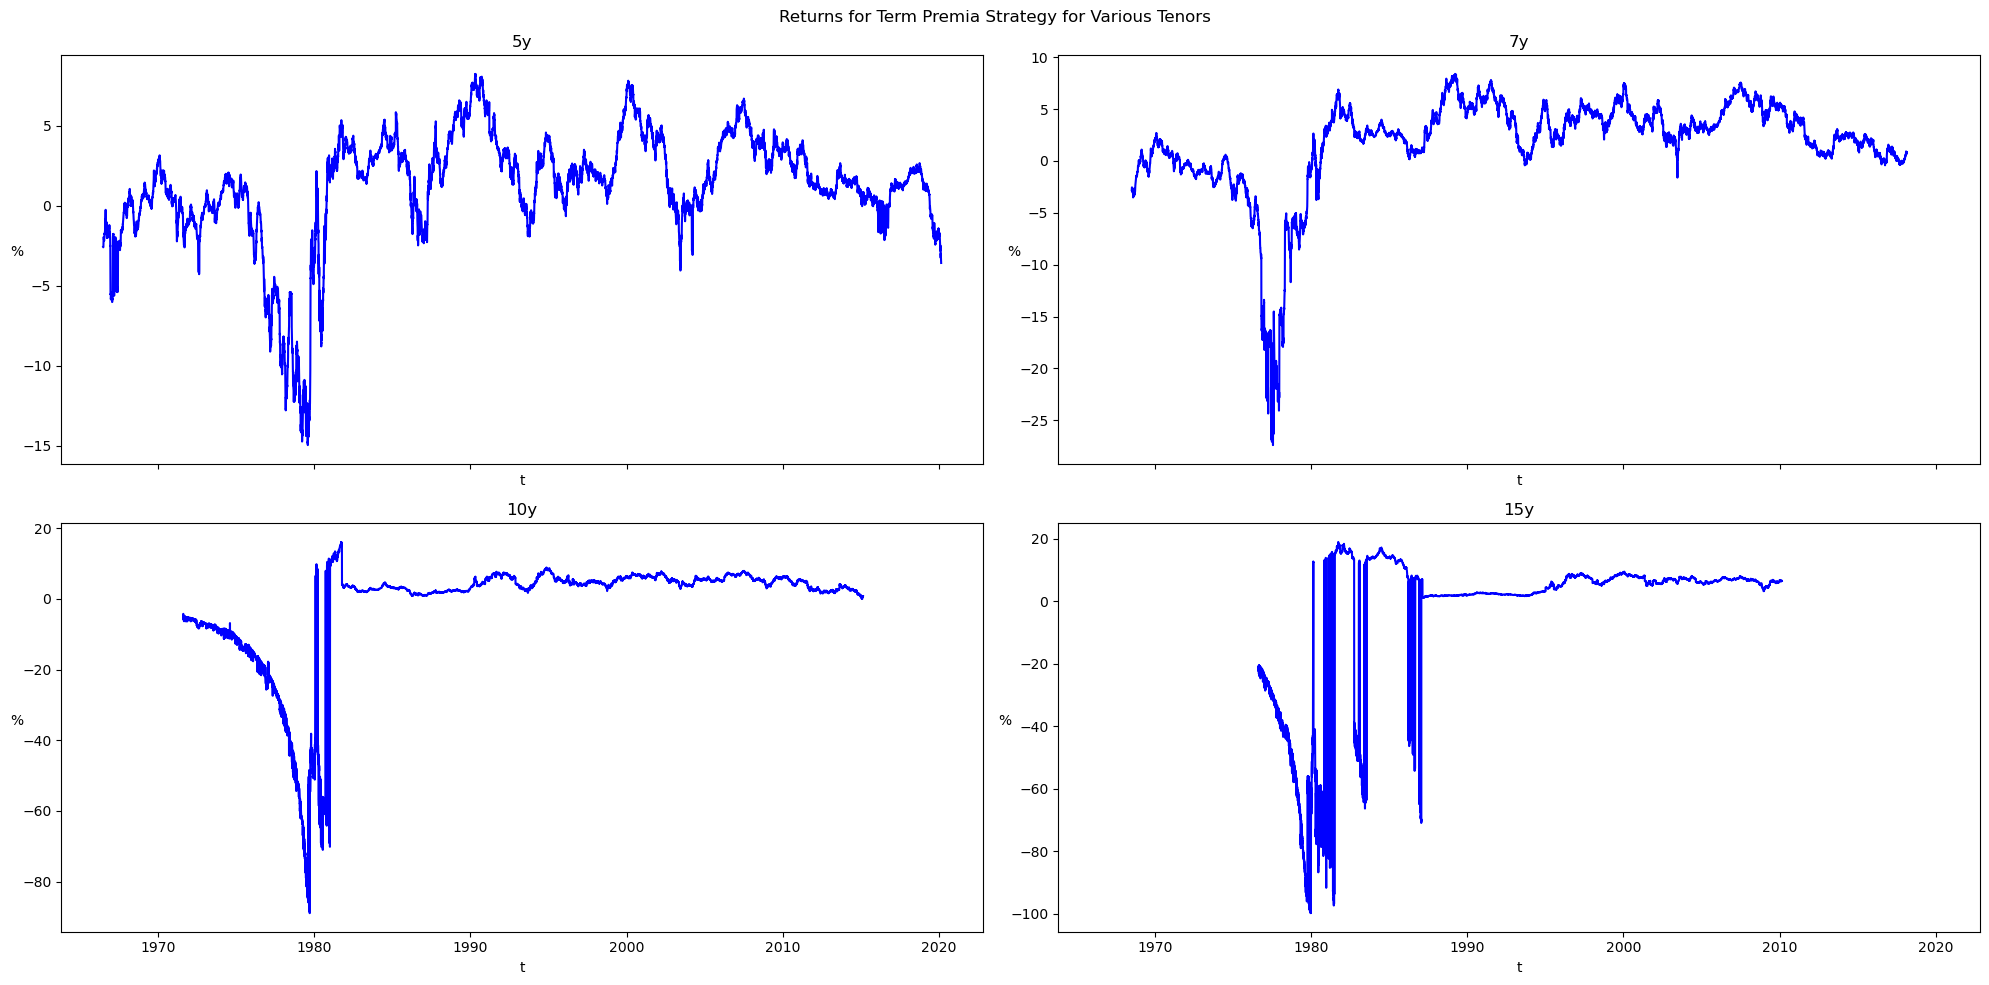

In [18]:
fig, axs = plt.subplots(nrows=(1+len(tenors))//2, ncols=2, figsize=(20, 4*(1+len(tenors))//2), sharex='all')
fig.suptitle('Returns for Term Premia Strategy for Various Tenors')
axs = axs.flatten()
for i, tenor in enumerate(tenors):
    axs[i].plot(ts1[i], 100*returns1[i], c='b')
    axs[i].set_title(f'{tenor}y')
    axs[i].set_ylabel('%', rotation=0)
    axs[i].set_xlabel('t')
plt.tight_layout()

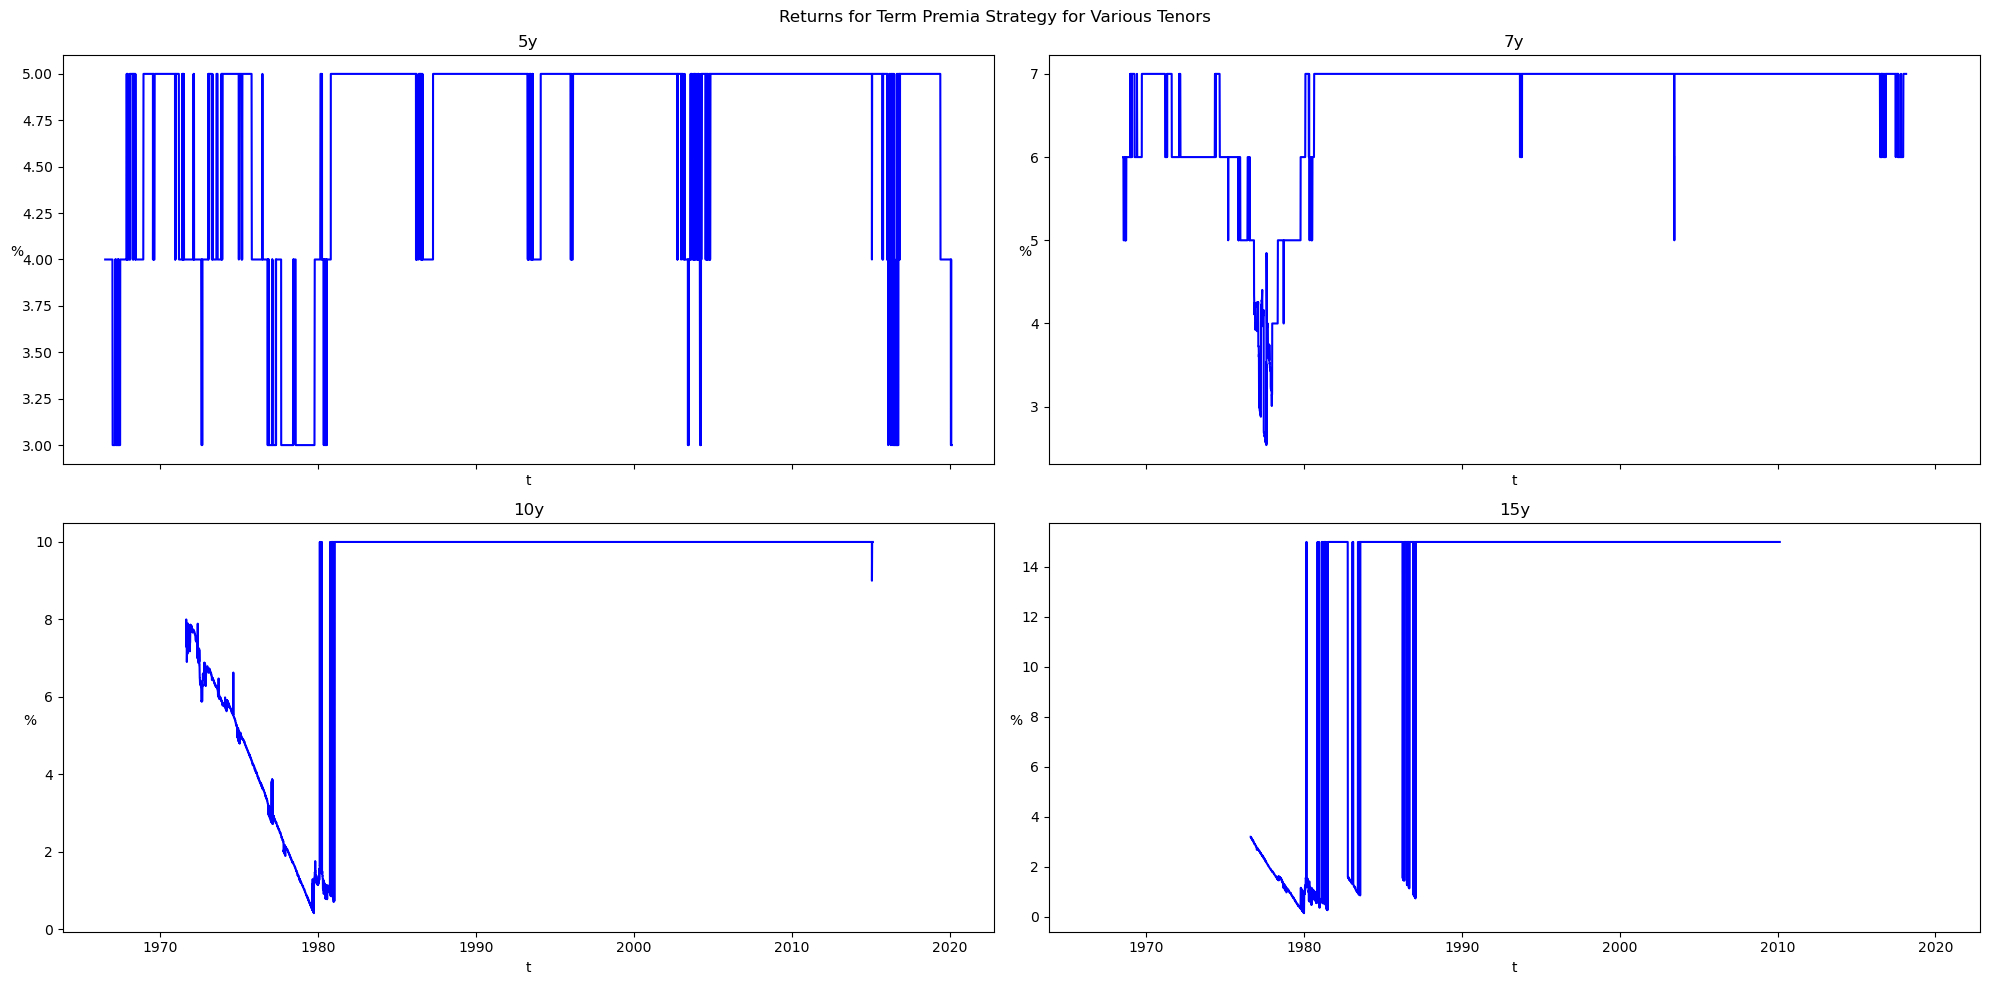

In [19]:
fig, axs = plt.subplots(nrows=(1+len(tenors))//2, ncols=2, figsize=(20, 4*(1+len(tenors))//2), sharex='all')
fig.suptitle('Returns for Term Premia Strategy for Various Tenors')
axs = axs.flatten()
for i, tenor in enumerate(tenors):
    axs[i].plot(ts1[i], termination_times1[i], c='b')
    axs[i].set_title(f'{tenor}y')
    axs[i].set_ylabel('%', rotation=0)
    axs[i].set_xlabel('t')
plt.tight_layout()

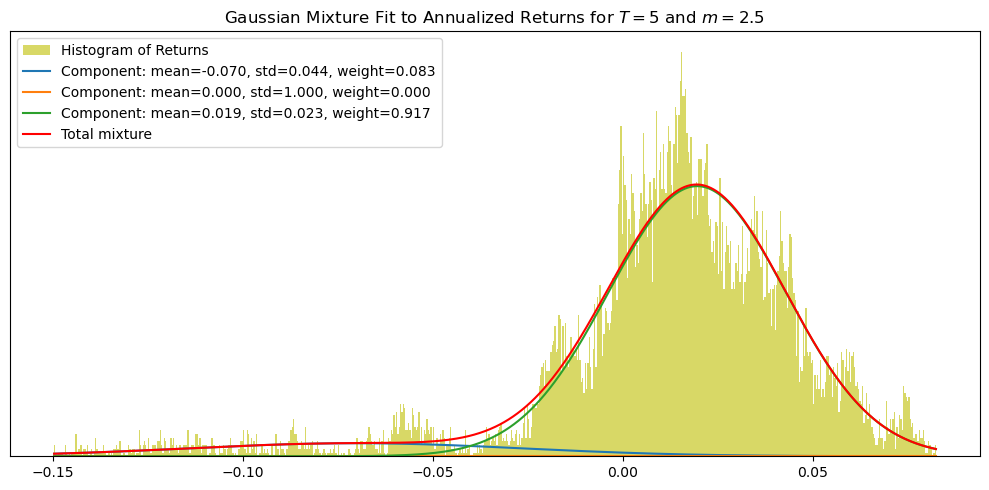

Analytical VaR (at α = 0.01): -0.1221
Analytical ES (at α = 0.01): -0.1437
Analytical VaR (at α = 0.05): -0.0598
Analytical ES (at α = 0.05): -0.0988

Empirical VaR (at α = 0.01): -0.1222
Empirical ES (at α = 0.01): -0.1339
Empirical VaR (at α = 0.05): -0.0582
Empirical ES (at α = 0.05): -0.0971


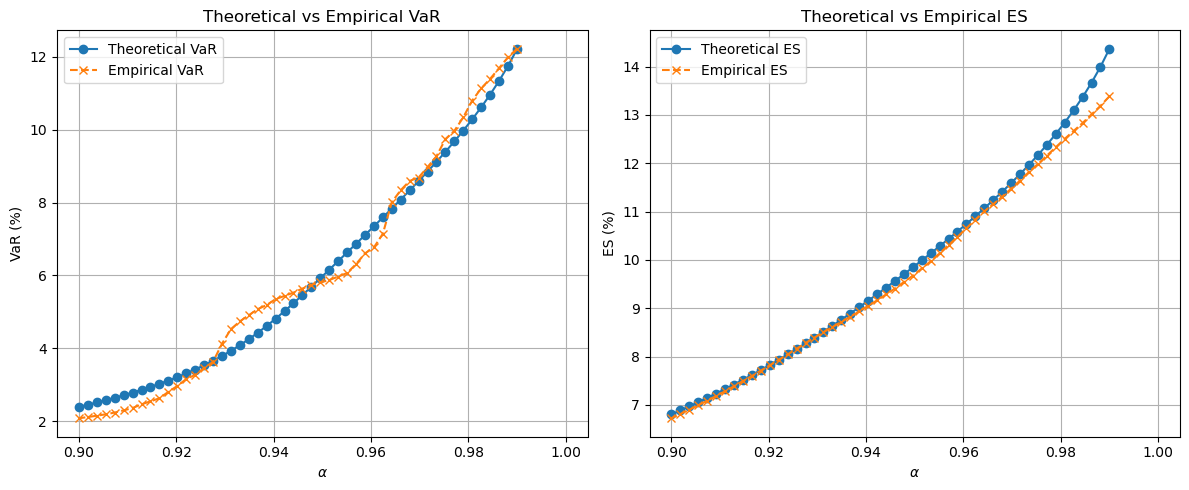

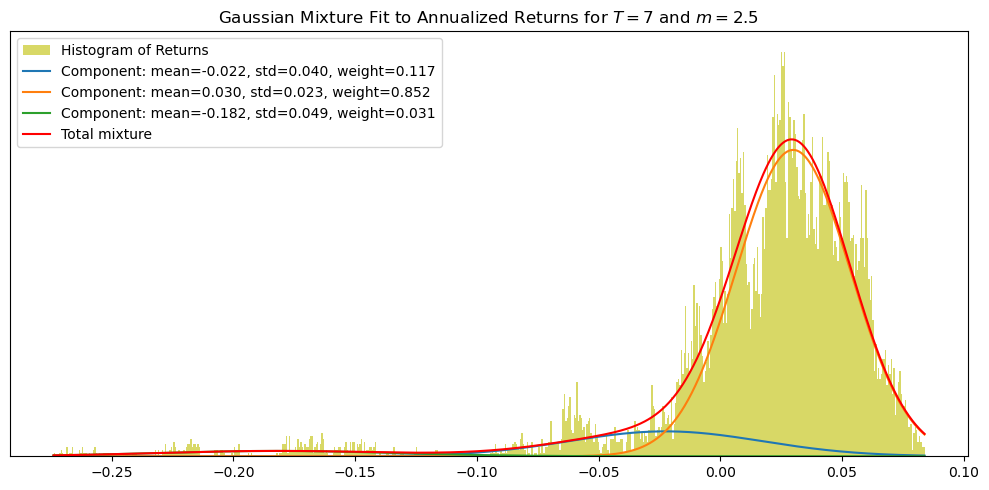

Analytical VaR (at α = 0.01): -0.2050
Analytical ES (at α = 0.01): -0.2369
Analytical VaR (at α = 0.05): -0.0616
Analytical ES (at α = 0.05): -0.1447

Empirical VaR (at α = 0.01): -0.2057
Empirical ES (at α = 0.01): -0.2334
Empirical VaR (at α = 0.05): -0.0620
Empirical ES (at α = 0.05): -0.1416


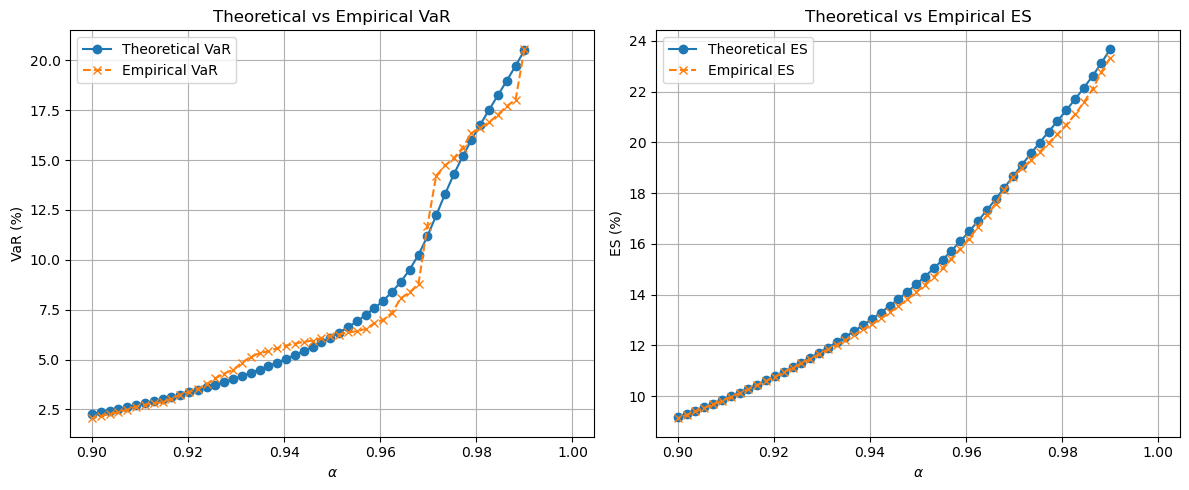

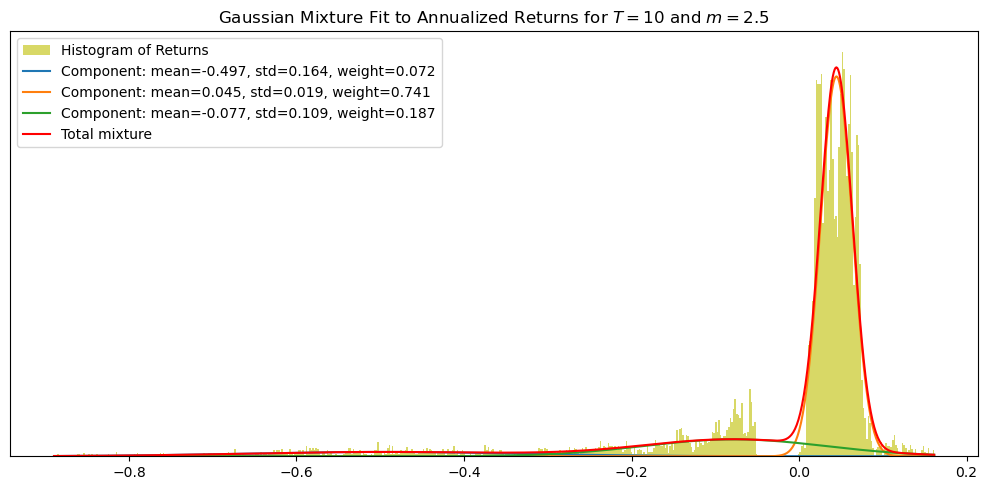

Analytical VaR (at α = 0.01): -0.6757
Analytical ES (at α = 0.01): -0.7591
Analytical VaR (at α = 0.05): -0.4161
Analytical ES (at α = 0.05): -0.5808

Empirical VaR (at α = 0.01): -0.6732
Empirical ES (at α = 0.01): -0.7654
Empirical VaR (at α = 0.05): -0.4187
Empirical ES (at α = 0.05): -0.5790


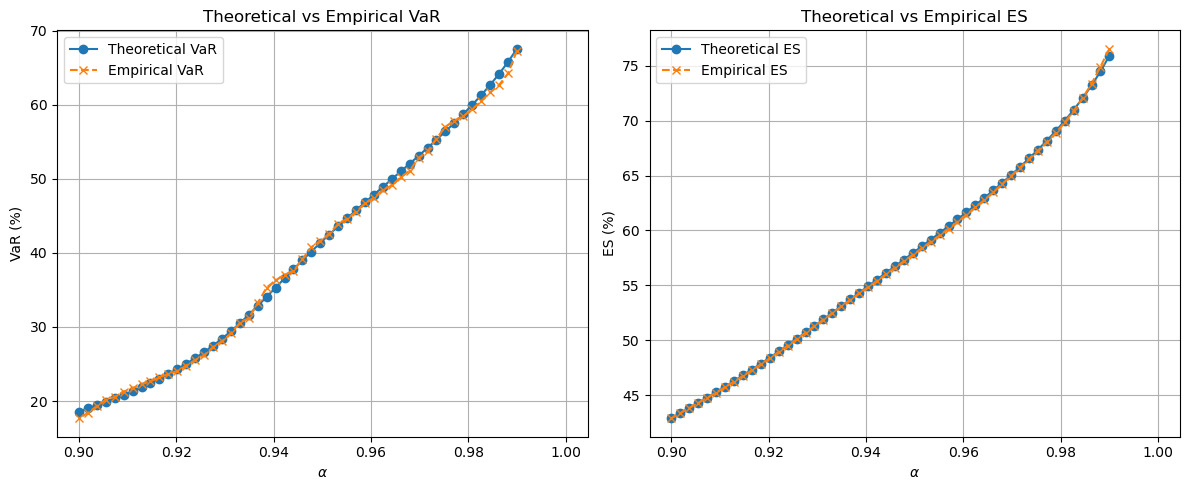

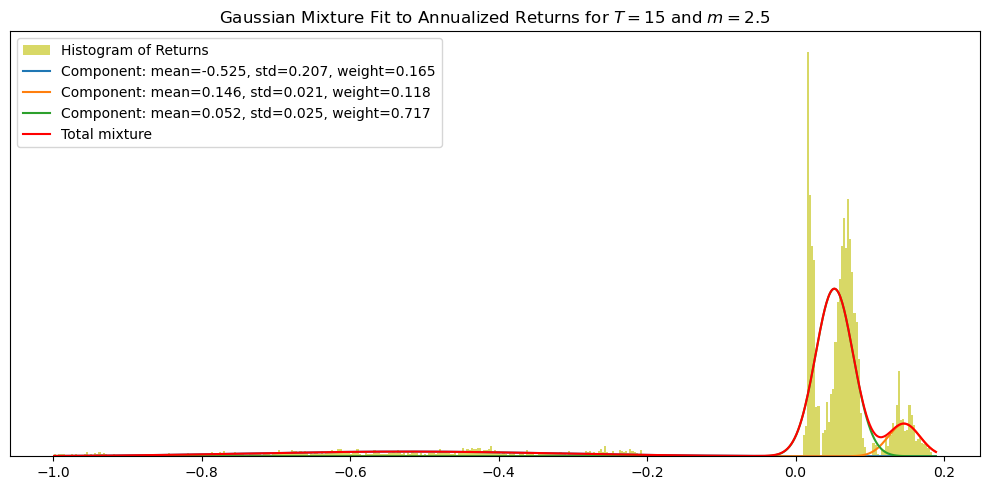

Analytical VaR (at α = 0.01): -0.8459
Analytical ES (at α = 0.01): -0.9352
Analytical VaR (at α = 0.05): -0.6317
Analytical ES (at α = 0.05): -0.7636

Empirical VaR (at α = 0.01): -0.8906
Empirical ES (at α = 0.01): -0.9497
Empirical VaR (at α = 0.05): -0.6366
Empirical ES (at α = 0.05): -0.7754


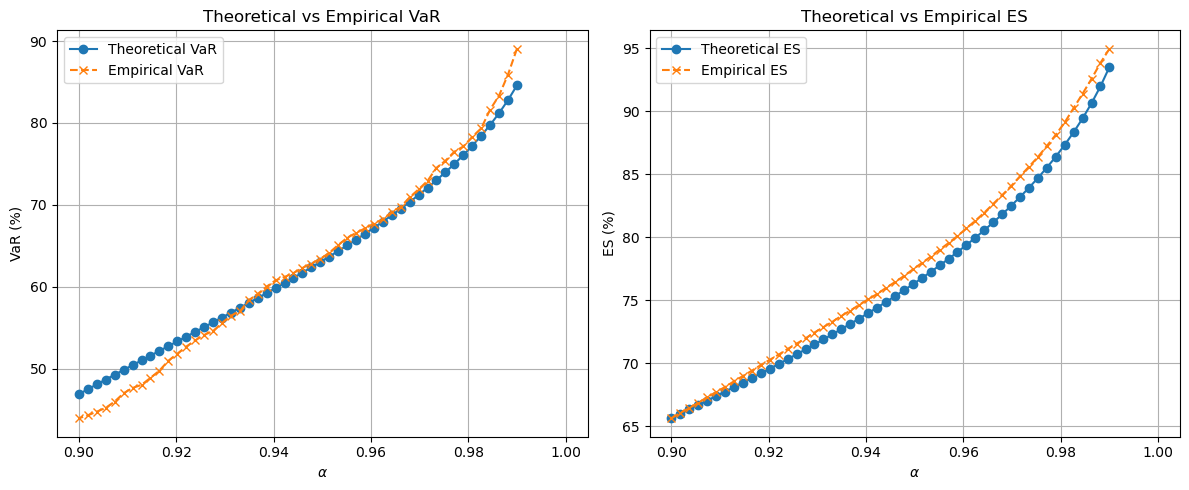

In [ ]:
#Plots for the report VAR ES
tenors = [5, 7, 10, 15]
vars, ess = [], []
m = 2.5
for j, t in enumerate(tenors):
    arr = returns1[j]
    p, mu, sigma = EM4GM(arr, 3, sig=(0,0,0))
    plot_results(arr, p, mu, sigma, rf'Gaussian Mixture Fit to Annualized Returns for $T={t}$ and $m={m}$', f'gaussian_mult_2_5_full_data_{t}.pdf')
    
    var = find_var(0.01, p, mu, sigma, lower=-10, upper=10)
    es = expected_shortfall(var, p, mu, sigma, 0.01)

    print("Analytical VaR (at α = {:.2f}): {:.4f}".format(0.01, var))
    print("Analytical ES (at α = {:.2f}): {:.4f}".format(0.01, es))

    var = find_var(0.05, p, mu, sigma, lower=-10, upper=10)
    es = expected_shortfall(var, p, mu, sigma, 0.05)

    print("Analytical VaR (at α = {:.2f}): {:.4f}".format(0.05, var))
    print("Analytical ES (at α = {:.2f}): {:.4f}".format(0.05, es))

    var_empirical, es_empirical = empirical_var_es(arr, 0.01)
    vars.append(var_empirical)
    ess.append(es_empirical)
    print("\nEmpirical VaR (at α = {:.2f}): {:.4f}".format(0.01, var_empirical))
    print("Empirical ES (at α = {:.2f}): {:.4f}".format(0.01, es_empirical))

    var_empirical, es_empirical = empirical_var_es(arr, 0.05)
    vars.append(var_empirical)
    ess.append(es_empirical)
    print("Empirical VaR (at α = {:.2f}): {:.4f}".format(0.05, var_empirical))
    print("Empirical ES (at α = {:.2f}): {:.4f}".format(0.05, es_empirical))

    alphas = np.linspace(0.01, 0.1, 50)

    theo_vars = []
    theo_ess = []
    emp_vars = []
    emp_ess = []

    for alpha in alphas:
        # Compute theoretical VaR and ES
        v = find_var(alpha, p, mu, sigma, lower=-10, upper=10)
        e = expected_shortfall(v, p, mu, sigma, alpha)
        theo_vars.append(v)
        theo_ess.append(e)
        
        # Compute empirical VaR and ES using the returns data
        v_emp, e_emp = empirical_var_es(arr, alpha)
        emp_vars.append(v_emp)
        emp_ess.append(e_emp)

    # Create the plots
    plt.figure(figsize=(12, 5))

    # VaR plot
    plt.subplot(1, 2, 1)
    plt.plot(1-alphas, [-100*v for v in theo_vars], label="Theoretical VaR", marker="o")
    plt.plot(1-alphas, [-100*v for v in emp_vars], label="Empirical VaR", linestyle="--", marker="x")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("VaR (%)")
    x_min, x_max = plt.xlim()
    plt.xlim([x_min, x_max+0.01])
    plt.title("Theoretical vs Empirical VaR")
    plt.legend()
    plt.grid(True)

    # ES plot
    plt.subplot(1, 2, 2)
    plt.plot(1-alphas, [-100*v for v in theo_ess], label="Theoretical ES", marker="o")
    plt.plot(1-alphas, [-100*v for v in emp_ess], label="Empirical ES", linestyle="--", marker="x")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("ES (%)")
    x_min, x_max = plt.xlim()
    plt.xlim([x_min, x_max+0.01])
    plt.title("Theoretical vs Empirical ES")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    

# Truncated

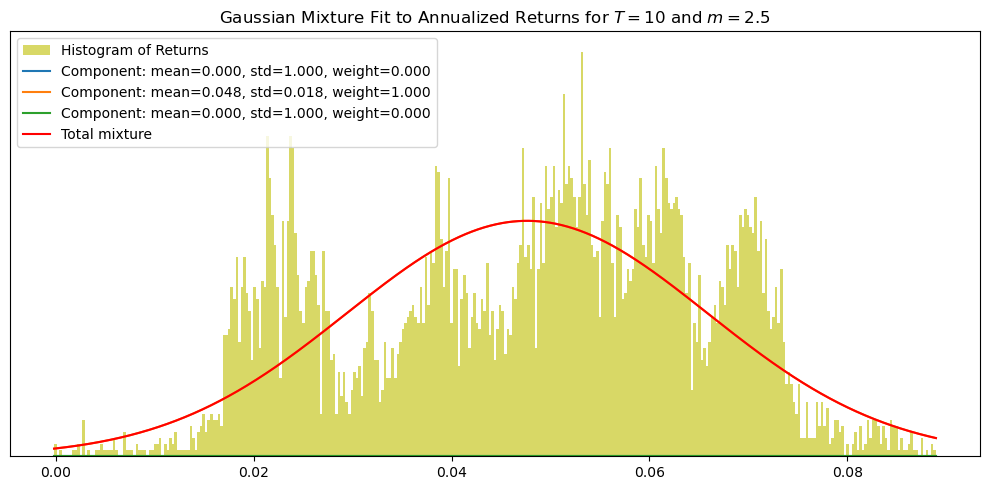

Analytical VaR (at α = 0.01): 0.0051
Analytical ES (at α = 0.01): -0.0010
Analytical VaR (at α = 0.05): 0.0176
Analytical ES (at α = 0.05): 0.0100


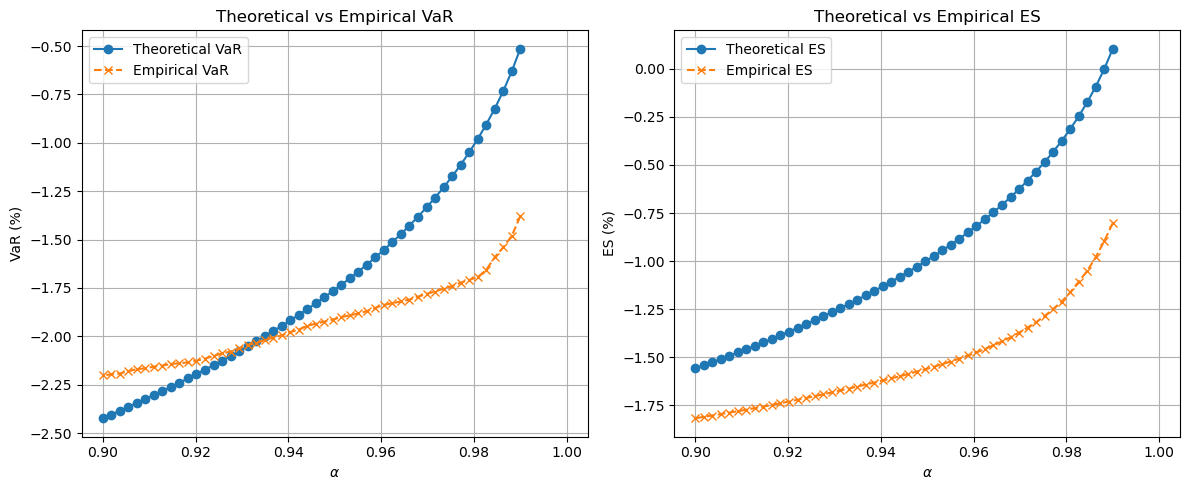

In [21]:
start_time = pd.Timestamp(year=1987, month=6, day=14)

arr = returns1[2][ts1[2] > start_time]
p, mu, sigma = EM4GM(arr, 3, sig=(0,0,0))
plot_results(arr, p, mu, sigma, rf'Gaussian Mixture Fit to Annualized Returns for $T=10$ and $m={m}$', f'gaussian_mult_2_5_CUT_10.pdf')

var = find_var(0.01, p, mu, sigma, lower=-10, upper=10)
es = expected_shortfall(var, p, mu, sigma, 0.01)
print("Analytical VaR (at α = {:.2f}): {:.4f}".format(0.01, var))
print("Analytical ES (at α = {:.2f}): {:.4f}".format(0.01, es))

var = find_var(0.05, p, mu, sigma, lower=-10, upper=10)
es = expected_shortfall(var, p, mu, sigma, 0.05)
print("Analytical VaR (at α = {:.2f}): {:.4f}".format(0.05, var))
print("Analytical ES (at α = {:.2f}): {:.4f}".format(0.05, es))

alphas = np.linspace(0.01, 0.1, 50)

theo_vars = []
theo_ess = []
emp_vars = []
emp_ess = []

for alpha in alphas:
    # Compute theoretical VaR and ES
    v = find_var(alpha, p, mu, sigma, lower=-10, upper=10)
    e = expected_shortfall(v, p, mu, sigma, alpha)
    theo_vars.append(v)
    theo_ess.append(e)
    
    # Compute empirical VaR and ES using the returns data
    v_emp, e_emp = empirical_var_es(arr, alpha)
    emp_vars.append(v_emp)
    emp_ess.append(e_emp)

# Create the plots
plt.figure(figsize=(12, 5))

# VaR plot
plt.subplot(1, 2, 1)
plt.plot(1-alphas, [-100*v for v in theo_vars], label="Theoretical VaR", marker="o")
plt.plot(1-alphas, [-100*v for v in emp_vars], label="Empirical VaR", linestyle="--", marker="x")
plt.xlabel(r"$\alpha$")
plt.ylabel("VaR (%)")
x_min, x_max = plt.xlim()
plt.xlim([x_min, x_max+0.01])
plt.title("Theoretical vs Empirical VaR")
plt.legend()
plt.grid(True)

# ES plot
plt.subplot(1, 2, 2)
plt.plot(1-alphas, [-100*v for v in theo_ess], label="Theoretical ES", marker="o")
plt.plot(1-alphas, [-100*v for v in emp_ess], label="Empirical ES", linestyle="--", marker="x")
plt.xlabel(r"$\alpha$")
plt.ylabel("ES (%)")
x_min, x_max = plt.xlim()
plt.xlim([x_min, x_max+0.01])
plt.title("Theoretical vs Empirical ES")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig(f'gaussian_mult_2_5_CUT_var_es_10.pdf', format='pdf')
plt.show()

In [22]:
print('Truncated Dataset')
for i, returns in enumerate(returns1):
    returns = returns[ts1[i] > start_time]
    var1 = np.quantile(returns, 0.05)
    temp1 = returns[returns < var1]
    var2 = np.quantile(returns, 0.01)
    temp2 = returns[returns < var2]
    print(f'var95 {var1}, var99 {var2}, es95 {temp1.mean()}, es99 {temp2.mean()}')

Truncated Dataset
var95 -0.00680758055457924, var99 -0.020791527415975678, es95 -0.016919109486106948, es99 -0.027637997096555542
var95 0.004113820412306834, var99 -0.0014158075011080906, es95 0.0004877172280725799, es99 -0.002543936964753146
var95 0.019108313731590477, var99 0.013801871970267925, es95 0.015605134283478777, es99 0.0080290395955283
var95 0.017121605355433833, var99 0.015847550227205253, es95 0.016313847283013615, es99 0.015391572937660986


## No ON vs ON (Excess Returns)

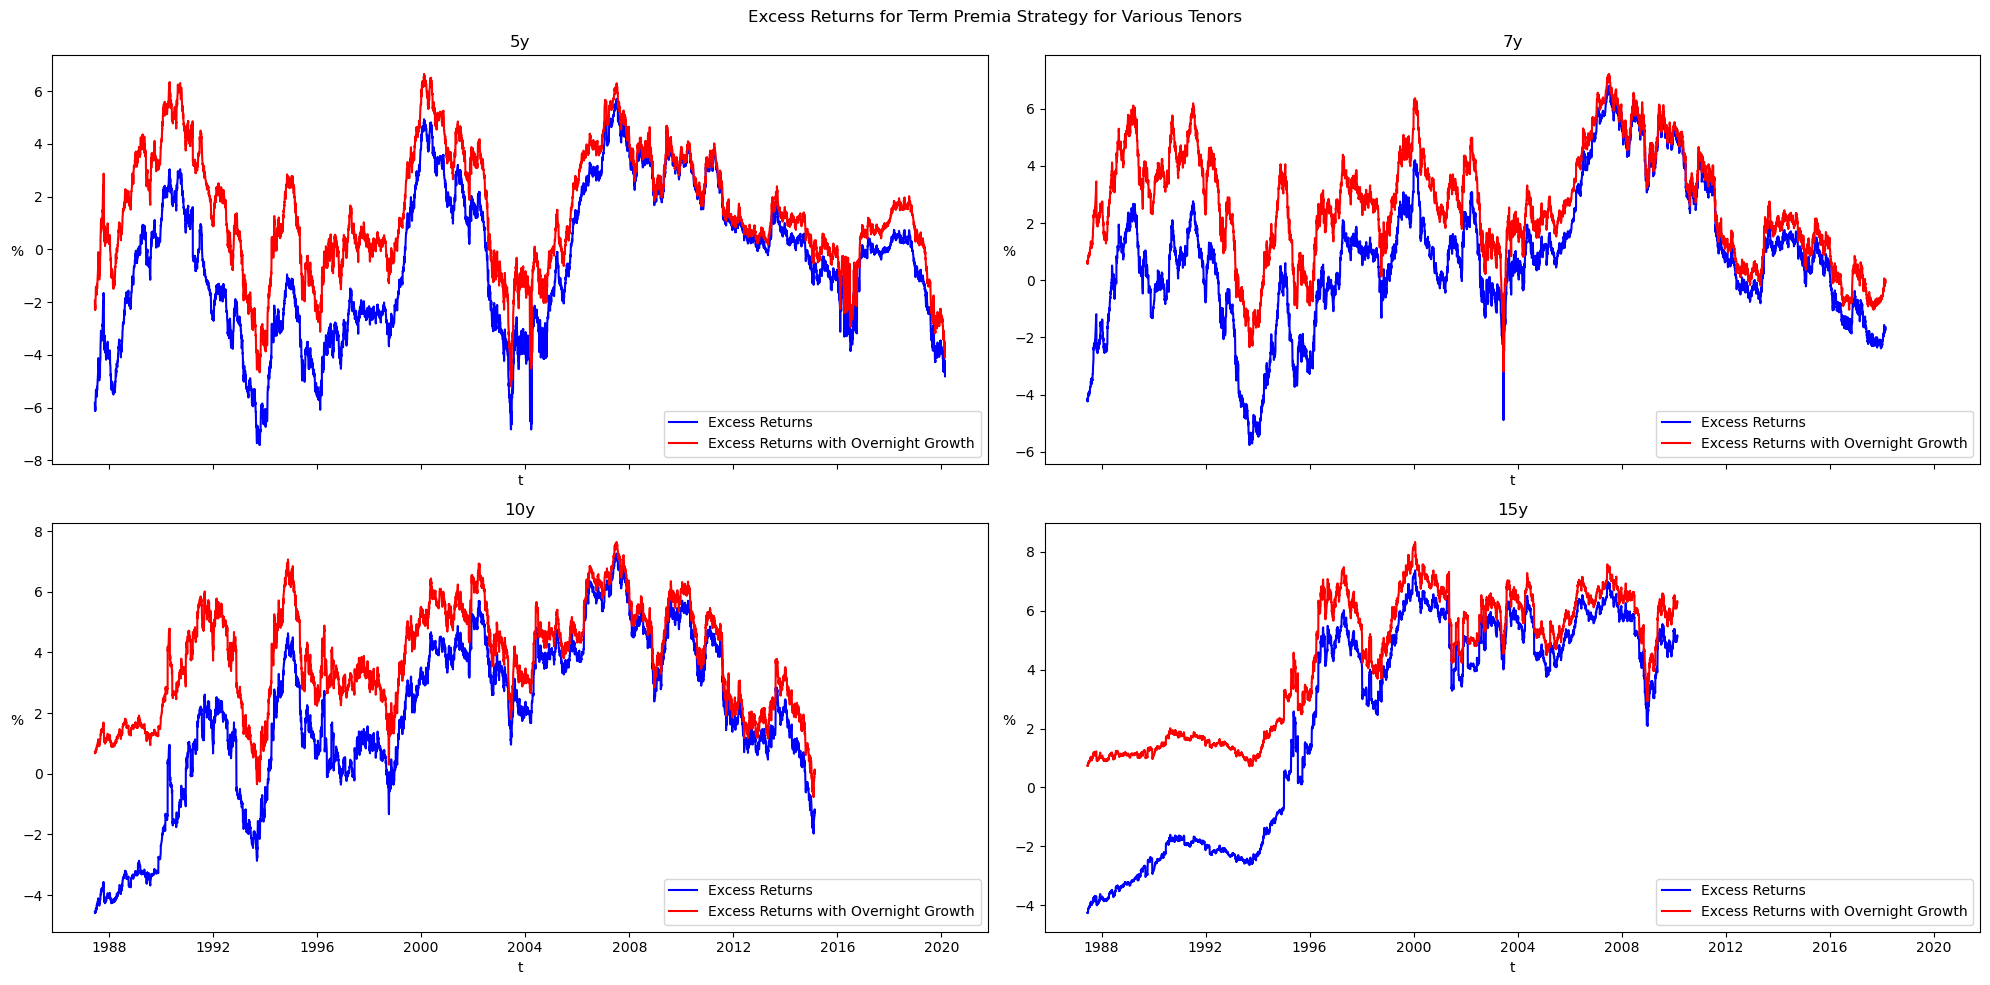

In [23]:
fig, axs = plt.subplots(nrows=(1+len(tenors))//2, ncols=2, figsize=(20, 4*(1+len(tenors))//2), sharex='all')
fig.suptitle('Excess Returns for Term Premia Strategy for Various Tenors')
axs = axs.flatten()
for i, tenor in enumerate(tenors):
    axs[i].plot(ts1[i][ts1[i] > start_time], 100*excess_returns1[i][ts1[i] > start_time], c='b')
    axs[i].plot(ts2[i][ts2[i] > start_time], 100*excess_returns2[i][ts2[i] > start_time], c='r')
    axs[i].set_title(f'{tenor}y')
    axs[i].set_ylabel('%', rotation=0)
    axs[i].set_xlabel('t')
    axs[i].legend(['Excess Returns', 'Excess Returns with Overnight Growth'], loc=4)
plt.tight_layout()
#plt.savefig('excess_returns_2_5_mult_overnight.pdf', format='pdf')

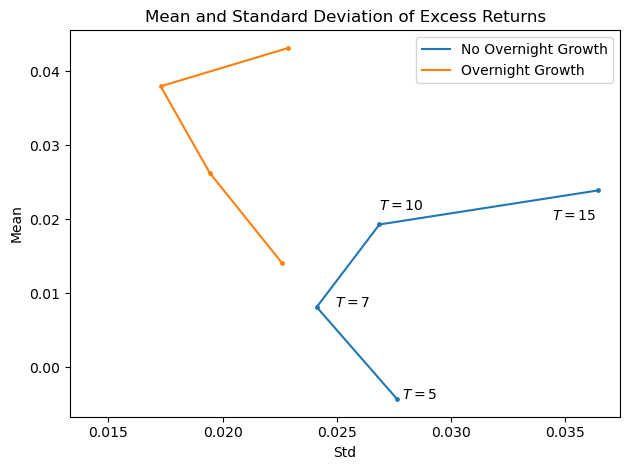

In [24]:
stds1 = np.array([np.std(returns[ts1[i] > start_time], ddof=1) for i, returns in enumerate(excess_returns1)])
means1 = np.array([np.mean(returns[ts1[i] > start_time]) for i, returns in enumerate(excess_returns1)])
stds2 = np.array([np.std(returns[ts2[i] > start_time], ddof=1) for i, returns in enumerate(excess_returns2)])
means2 = np.array([np.mean(returns[ts2[i] > start_time]) for i, returns in enumerate(excess_returns2)])

plt.plot(stds1, means1, label = "No Overnight Growth")
plt.scatter(stds1, means1, s=6)
plt.plot(stds2, means2, label = "Overnight Growth")
plt.scatter(stds2, means2, s=6)
plt.legend()
x_min, x_max = plt.xlim()
plt.xlim(x_min-0.003, x_max)
plt.ylabel('Mean')
plt.xlabel('Std')
plt.annotate(rf'$T=5$', xy=(stds1[0]+0.0002, means1[0]))
plt.annotate(rf'$T=7$', xy=(stds1[1]+0.0008, means1[1]))
plt.annotate(rf'$T=10$', xy=(stds1[2], means1[2]+0.002))
plt.annotate(rf'$T=15$', xy=(stds1[3]-0.002, means1[3]-0.004))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.005))
plt.title('Mean and Standard Deviation of Excess Returns')
plt.tight_layout()
#plt.savefig('overnight_mean_stds.pdf', format='pdf')

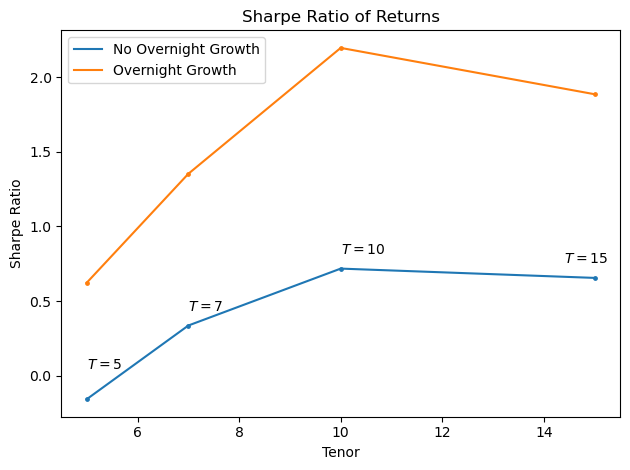

In [25]:
sharpes1, sharpes2 = means1/stds1, means2/stds2

plt.plot(tenors, sharpes1, label = "No Overnight Growth")
plt.scatter(tenors, sharpes1, s=6)
plt.plot(tenors, sharpes2, label = "Overnight Growth")
plt.scatter(tenors, sharpes2, s=6)
plt.annotate(rf'$T=5$', xy=(tenors[0], sharpes1[0]+0.2))
plt.annotate(rf'$T=7$', xy=(tenors[1], sharpes1[1]+0.1))
plt.annotate(rf'$T=10$', xy=(tenors[2]+0.001, sharpes1[2]+0.1))
plt.annotate(rf'$T=15$', xy=(tenors[3]-0.6, sharpes1[3]+0.1))
plt.legend()
plt.ylabel('Sharpe Ratio')
plt.xlabel('Tenor')
plt.title('Sharpe Ratio of Returns')
plt.tight_layout()
#plt.savefig('overnight_sharpes.pdf', format='pdf')

Strategy run starting 1998-10-05 has the highest drawdown of 50.2% (No ON) and 48.36% (With ON)


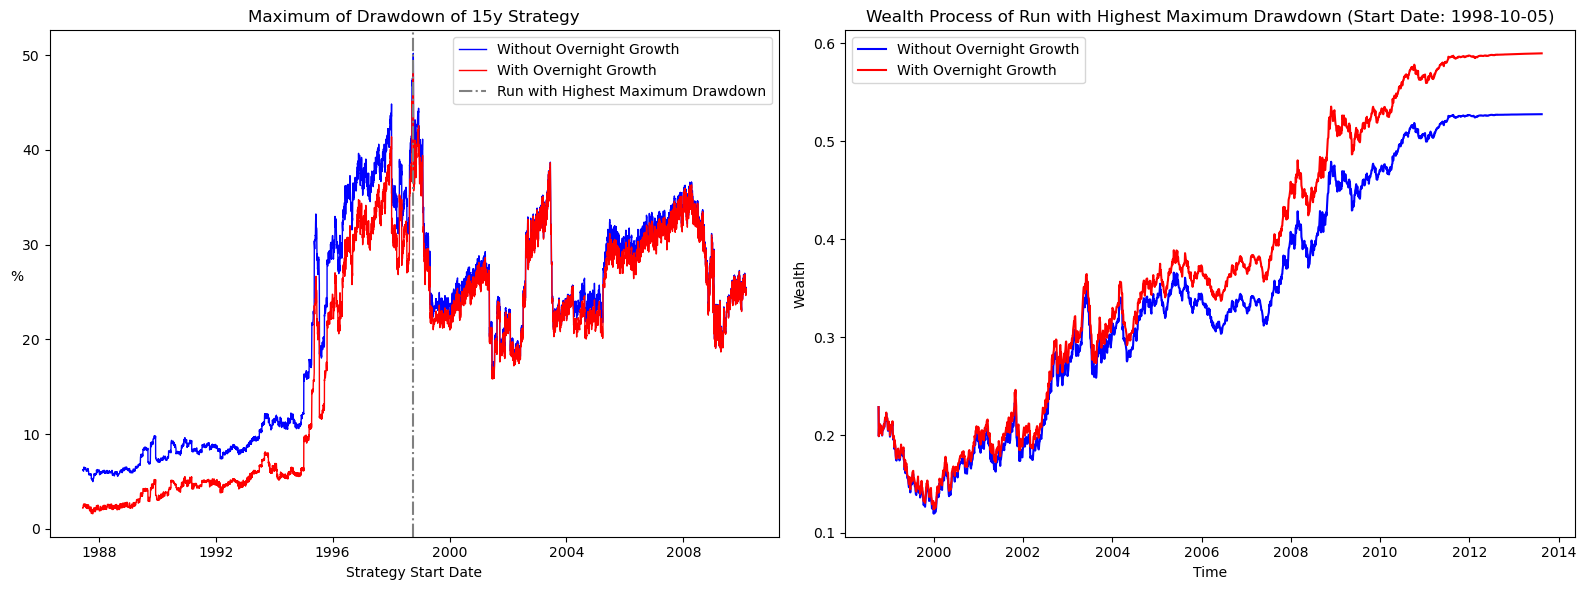

In [26]:
worst_dd_time = ts3[3][5511]
print('Strategy run starting', worst_dd_time.strftime('%Y-%m-%d'), f'has the highest drawdown of {np.round(100*max_drawdown1[3][5511], 2)}% (No ON) and {np.round(100*max_drawdown2[3][5511], 2)}% (With ON)')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axs[0].plot(ts1[3][ts1[3] > start_time], 100*max_drawdown1[3][ts1[3] > start_time], c='b', linewidth=1)
axs[0].plot(ts2[3][ts2[3] > start_time], 100*max_drawdown2[3][ts2[3] > start_time], c='r', linewidth=1)
axs[0].axvline(x=worst_dd_time, c='grey', linestyle='-.')
axs[0].set_title('Maximum of Drawdown of 15y Strategy')
axs[0].set_xlabel('Strategy Start Date')
axs[0].set_ylabel('%', rotation=0)
axs[0].legend(['Without Overnight Growth', 'With Overnight Growth', 'Run with Highest Maximum Drawdown'], loc=1)

worst_dd_time_index = zero_bond_prices.index.get_loc(worst_dd_time)
axs[1].plot(zero_bond_prices.index[worst_dd_time_index:worst_dd_time_index+2*len(wealth1[3][5511]):2], wealth1[3][5511], c='b')
axs[1].plot(zero_bond_prices.index[worst_dd_time_index:worst_dd_time_index+2*len(wealth2[3][5511]):2], wealth2[3][5511], c='r')
axs[1].set_title('Wealth Process of Run with Highest Maximum Drawdown (Start Date: ' + worst_dd_time.strftime('%Y-%m-%d') + ')')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Wealth')
axs[1].legend(['Without Overnight Growth', 'With Overnight Growth'])

plt.tight_layout()
#plt.savefig('drawdown_wealth.pdf', format='pdf')

In [27]:
print('Overnight Growth')
for i, returns in enumerate(returns2):
    returns = returns[ts2[i] > start_time]
    var1 = np.quantile(returns, 0.05)
    temp1 = returns[returns < var1]
    var2 = np.quantile(returns, 0.01)
    temp2 = returns[returns < var2]
    print(f'var95 {var1}, var99 {var2}, es95 {temp1.mean()}, es99 {temp2.mean()}')

Overnight Growth
var95 0.008329541846318844, var99 -0.008074964712181573, es95 -0.0029767274463651542, es99 -0.01397328093779523
var95 0.013961193049279518, var99 0.009527791687952036, es95 0.010891371990680061, es99 0.006602219642567196
var95 0.02967714770323222, var99 0.02268580467473222, es95 0.024907846037319503, es99 0.01933005437056331
var95 0.053897248487174455, var99 0.050447410589377274, es95 0.05118994723006487, es99 0.04707138903795612


## Unwound After 1 Year

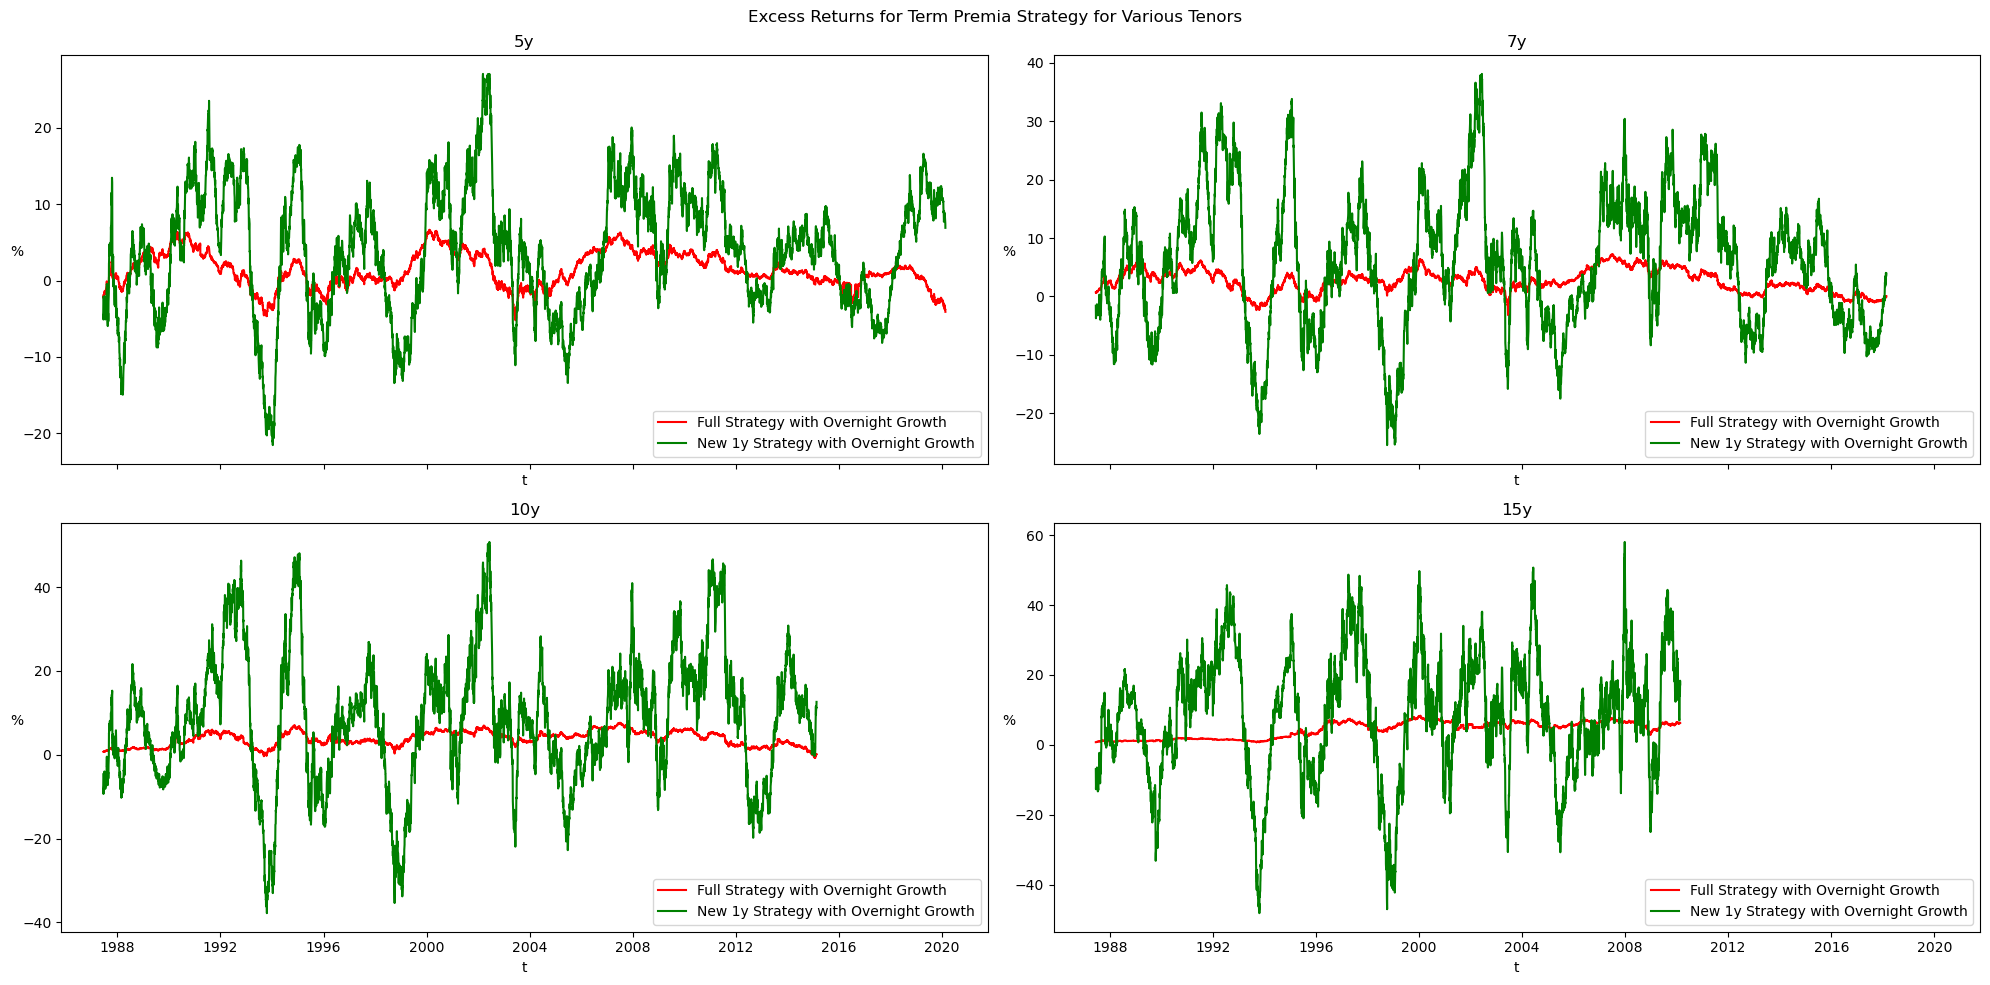

In [28]:
fig, axs = plt.subplots(nrows=(1+len(tenors))//2, ncols=2, figsize=(20, 4*(1+len(tenors))//2), sharex='all')
fig.suptitle('Excess Returns for Term Premia Strategy for Various Tenors')
axs = axs.flatten()
for i, tenor in enumerate(tenors):
    axs[i].plot(ts2[i][ts2[i] > start_time], 100*excess_returns2[i][ts2[i] > start_time], c='r')
    axs[i].plot(ts3[i][ts3[i] > start_time], 100*excess_returns3[i][ts3[i] > start_time], c='g')
    axs[i].set_title(f'{tenor}y')
    axs[i].set_ylabel('%', rotation=0)
    axs[i].set_xlabel('t')
    axs[i].legend(['Full Strategy with Overnight Growth', 'New 1y Strategy with Overnight Growth'], loc=4)
plt.tight_layout()
#plt.savefig('unwound_excess_returns.pdf', format='pdf')

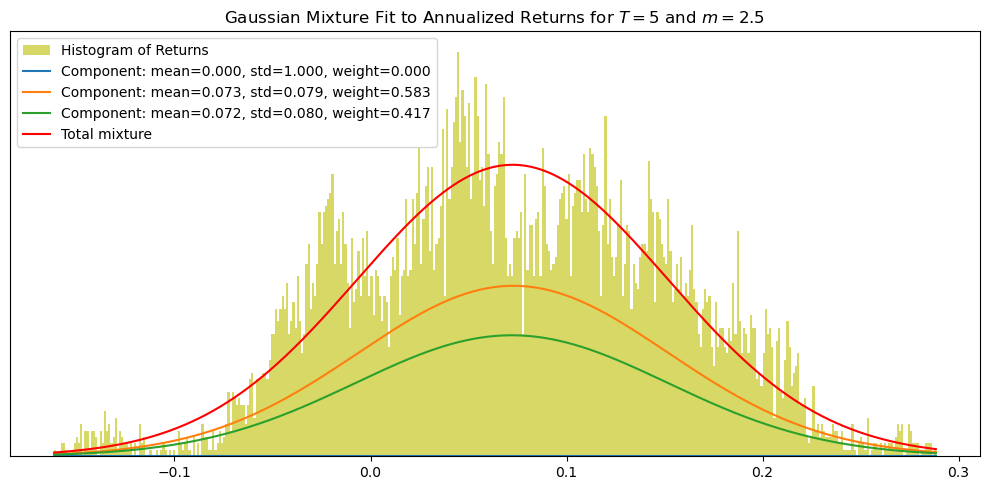

Analytical VaR (at α = 0.01): -0.1119
Analytical ES (at α = 0.01): -0.1388
Analytical VaR (at α = 0.05): -0.0579
Analytical ES (at α = 0.05): -0.0910


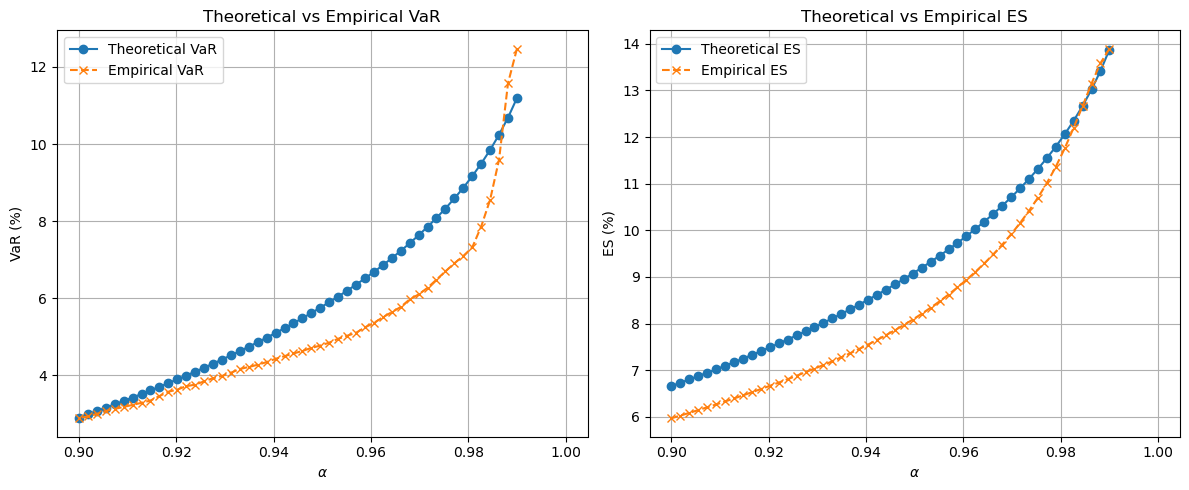

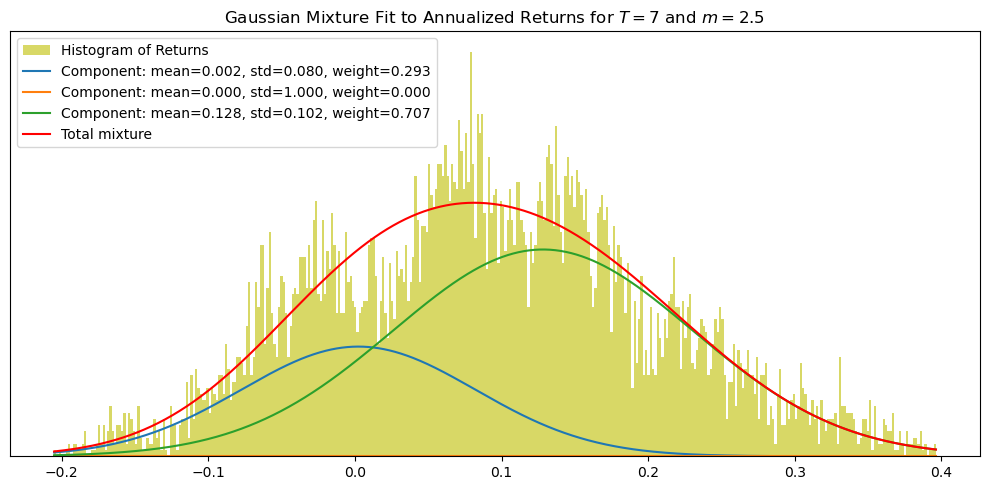

Analytical VaR (at α = 0.01): -0.1522
Analytical ES (at α = 0.01): -0.1828
Analytical VaR (at α = 0.05): -0.0882
Analytical ES (at α = 0.05): -0.1274


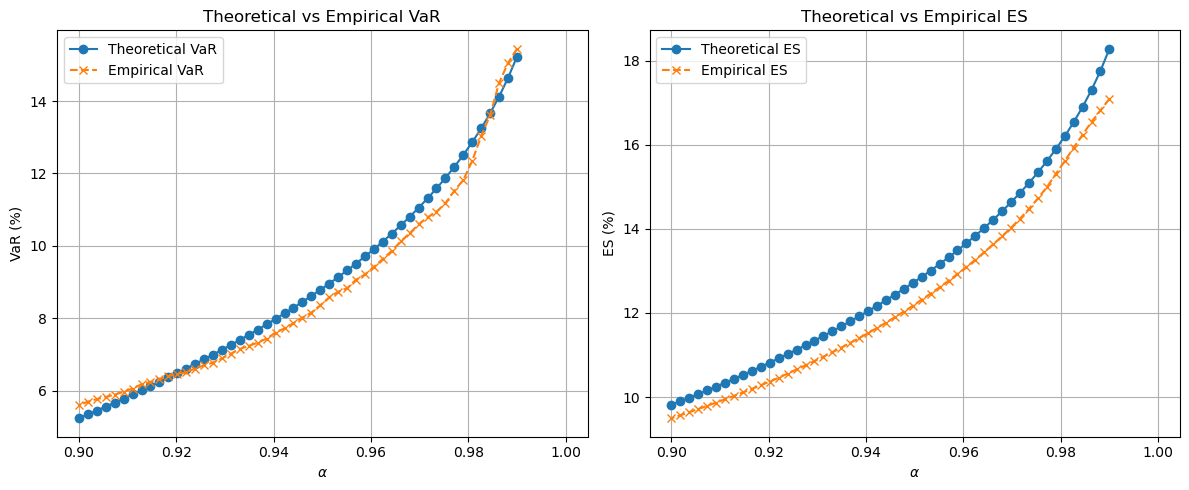

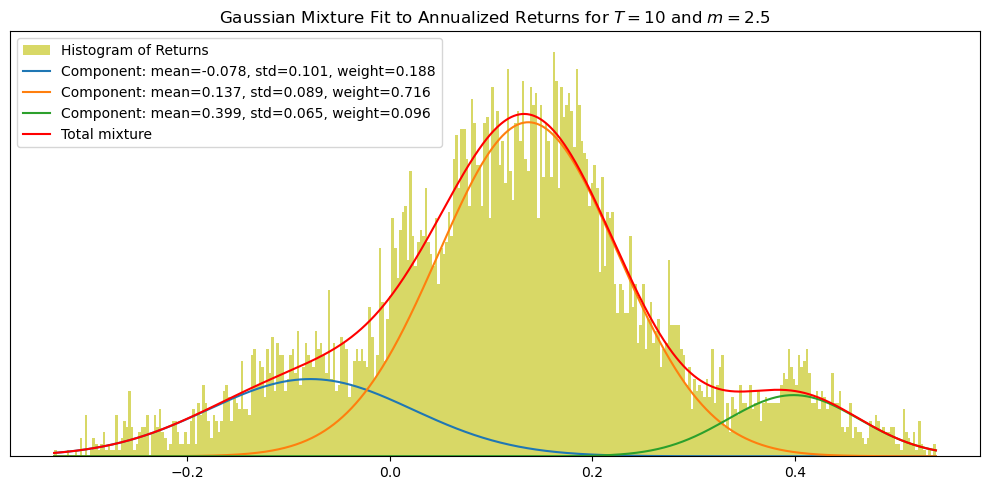

Analytical VaR (at α = 0.01): -0.2411
Analytical ES (at α = 0.01): -0.2837
Analytical VaR (at α = 0.05): -0.1423
Analytical ES (at α = 0.05): -0.2030


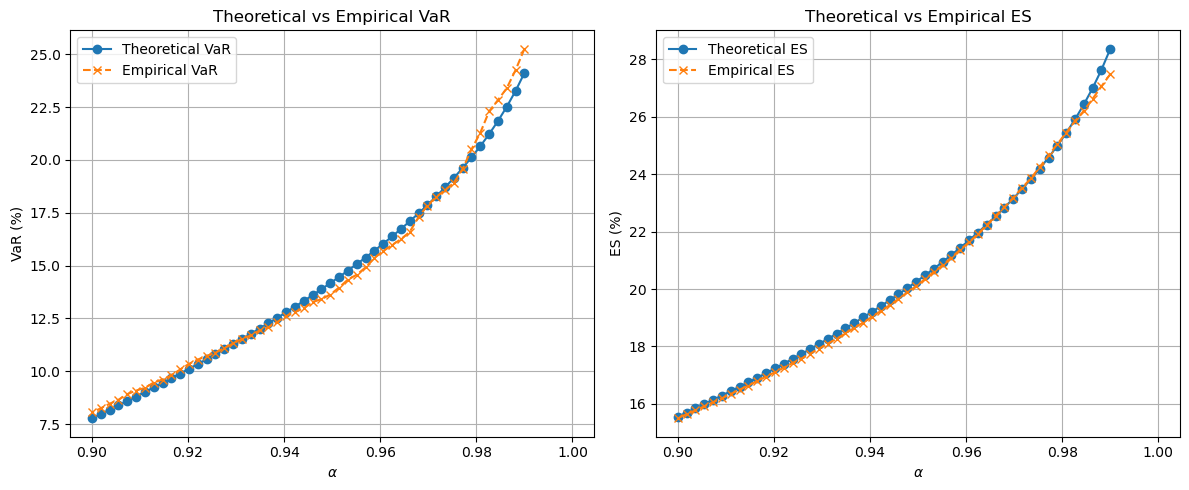

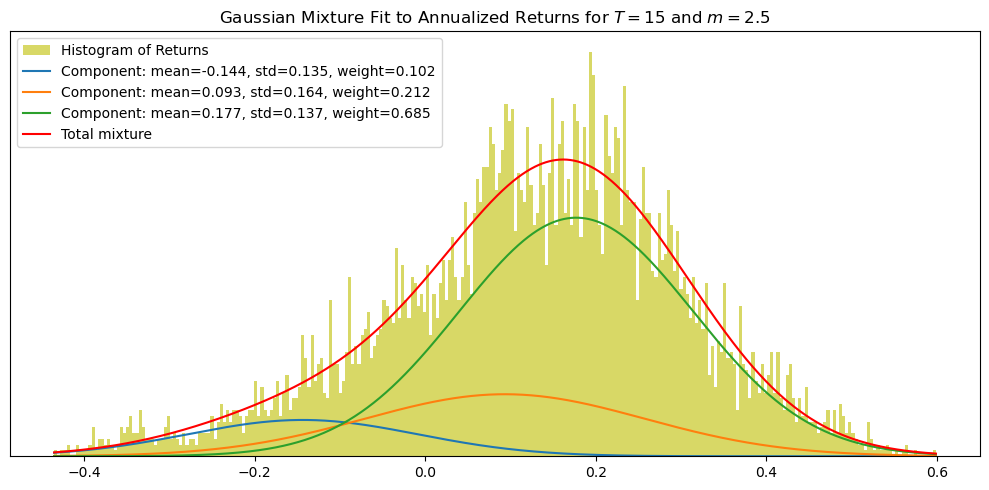

Analytical VaR (at α = 0.01): -0.3275
Analytical ES (at α = 0.01): -0.3882
Analytical VaR (at α = 0.05): -0.1875
Analytical ES (at α = 0.05): -0.2731


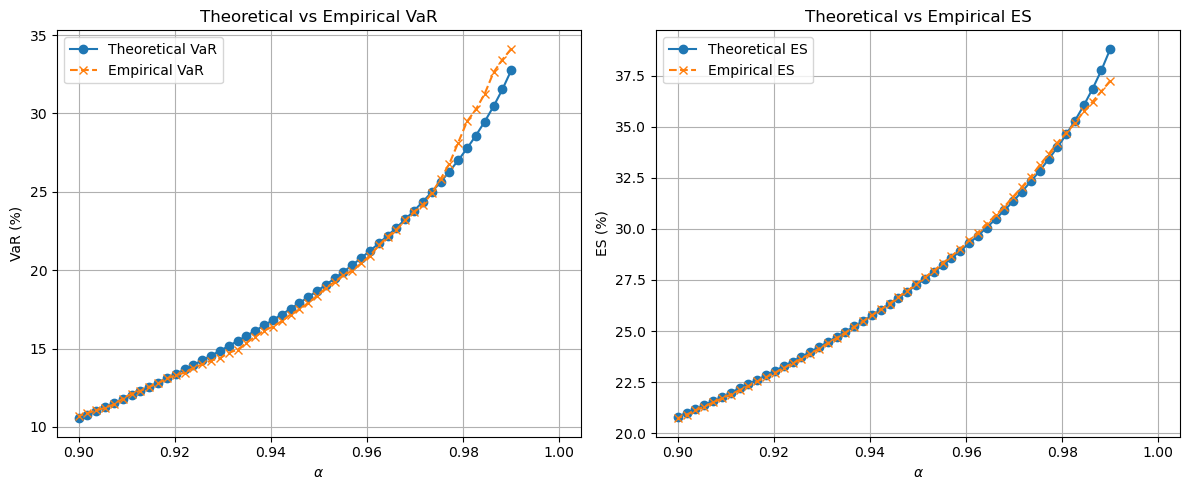

In [29]:
tenors = [5, 7, 10, 15]
vars, ess = [], []
m = 2.5
for j, t in enumerate(tenors):
    arr = returns3[j][ts3[j] > start_time]
    p, mu, sigma = EM4GM(arr, 3, sig=(0,0,0))
    plot_results(arr, p, mu, sigma, rf'Gaussian Mixture Fit to Annualized Returns for $T={t}$ and $m={m}$', f'1y_CUT_gaussian_mult_2_5_{t}.pdf')
    
    var = find_var(0.01, p, mu, sigma, lower=-10, upper=10)
    es = expected_shortfall(var, p, mu, sigma, 0.01)
    print("Analytical VaR (at α = {:.2f}): {:.4f}".format(0.01, var))
    print("Analytical ES (at α = {:.2f}): {:.4f}".format(0.01, es))
    
    var = find_var(0.05, p, mu, sigma, lower=-10, upper=10)
    es = expected_shortfall(var, p, mu, sigma, 0.05)
    print("Analytical VaR (at α = {:.2f}): {:.4f}".format(0.05, var))
    print("Analytical ES (at α = {:.2f}): {:.4f}".format(0.05, es))
    
    alphas = np.linspace(0.01, 0.1, 50)
    
    theo_vars = []
    theo_ess = []
    emp_vars = []
    emp_ess = []
    
    for a in alphas:
        # Compute theoretical VaR and ES
        v = find_var(a, p, mu, sigma, lower=-10, upper=10)
        e = expected_shortfall(v, p, mu, sigma, alpha)
        theo_vars.append(v)
        theo_ess.append(e)
        
        # Compute empirical VaR and ES using the returns data
        v_emp, e_emp = empirical_var_es(arr, a)
        emp_vars.append(v_emp)
        emp_ess.append(e_emp)
    
    # Create the plots
    plt.figure(figsize=(12, 5))
    
    # VaR plot
    plt.subplot(1, 2, 1)
    plt.plot(1-alphas, [-100*v for v in theo_vars], label="Theoretical VaR", marker="o")
    plt.plot(1-alphas, [-100*v for v in emp_vars], label="Empirical VaR", linestyle="--", marker="x")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("VaR (%)")
    x_min, x_max = plt.xlim()
    plt.xlim([x_min, x_max+0.01])
    plt.title("Theoretical vs Empirical VaR")
    plt.legend()
    plt.grid(True)
    
    # ES plot
    plt.subplot(1, 2, 2)
    plt.plot(1-alphas, [-100*v for v in theo_ess], label="Theoretical ES", marker="o")
    plt.plot(1-alphas, [-100*v for v in emp_ess], label="Empirical ES", linestyle="--", marker="x")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("ES (%)")
    x_min, x_max = plt.xlim()
    plt.xlim([x_min, x_max+0.01])
    plt.title("Theoretical vs Empirical ES")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f'1y_CUT_gaussian_mult_2_5_var_es_{t}.pdf', format='pdf')

Strategy run starting 1998-10-05 has the highest drawdown of 41.77%


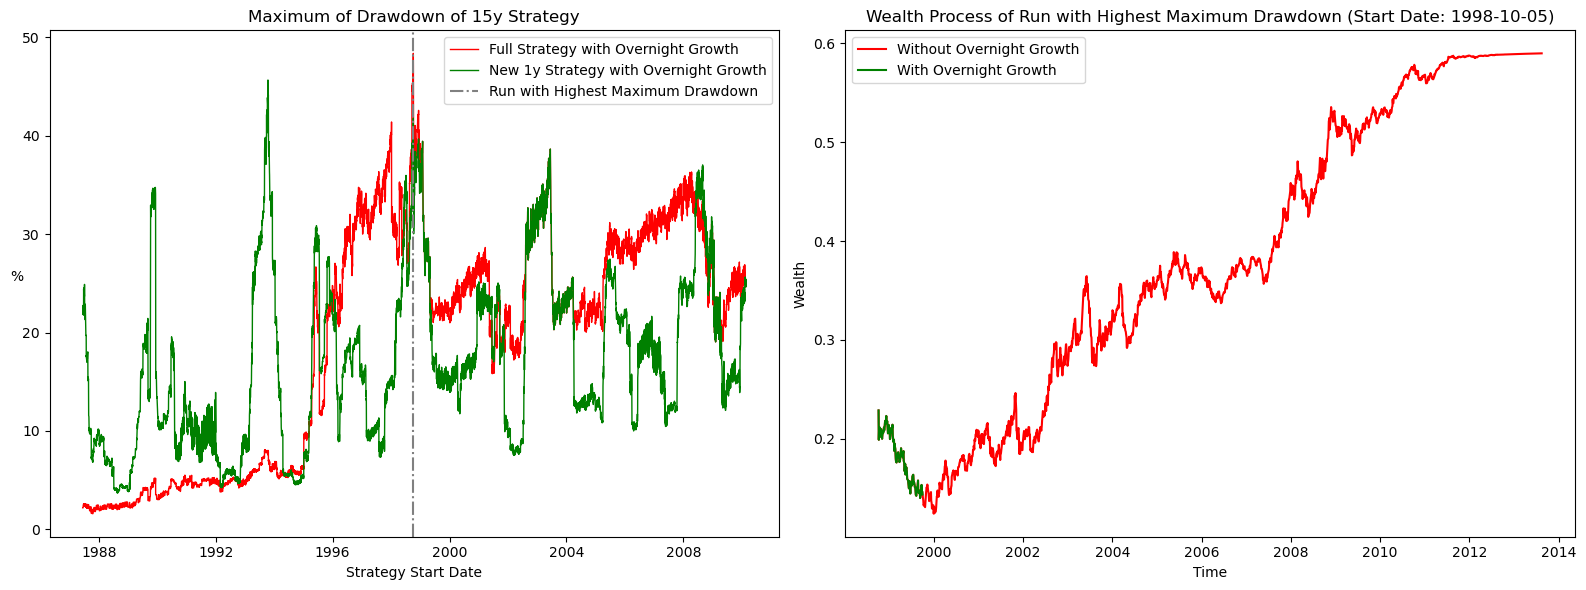

In [36]:
worst_dd_time = ts3[3][5511]
print('Strategy run starting', worst_dd_time.strftime('%Y-%m-%d'), f'has the highest drawdown of {np.round(100*max_drawdown3[3][5511], 2)}%')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axs[0].plot(ts2[3][ts2[3] > start_time], 100*max_drawdown2[3][ts2[3] > start_time], c='r', linewidth=1)
axs[0].plot(ts3[3][ts3[3] > start_time], 100*max_drawdown3[3][ts3[3] > start_time], c='g', linewidth=1)
axs[0].axvline(x=worst_dd_time, c='grey', linestyle='-.')
axs[0].set_title('Maximum of Drawdown of 15y Strategy')
axs[0].set_xlabel('Strategy Start Date')
axs[0].set_ylabel('%', rotation=0)
axs[0].legend(['Full Strategy with Overnight Growth', 'New 1y Strategy with Overnight Growth', 'Run with Highest Maximum Drawdown'], loc=1)

worst_dd_time_index = zero_bond_prices.index.get_loc(worst_dd_time)
axs[1].plot(zero_bond_prices.index[worst_dd_time_index:worst_dd_time_index+2*len(wealth2[3][5511]):2], wealth2[3][5511], c='r')
axs[1].plot(zero_bond_prices.index[worst_dd_time_index:worst_dd_time_index+2*len(wealth3[3][5511]):2], wealth3[3][5511], c='g')
axs[1].set_title('Wealth Process of Run with Highest Maximum Drawdown (Start Date: ' + worst_dd_time.strftime('%Y-%m-%d') + ')')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Wealth')
axs[1].legend(['Without Overnight Growth', 'With Overnight Growth'])

plt.tight_layout()
#plt.savefig('unwound_drawdown_wealth.pdf', format='pdf')

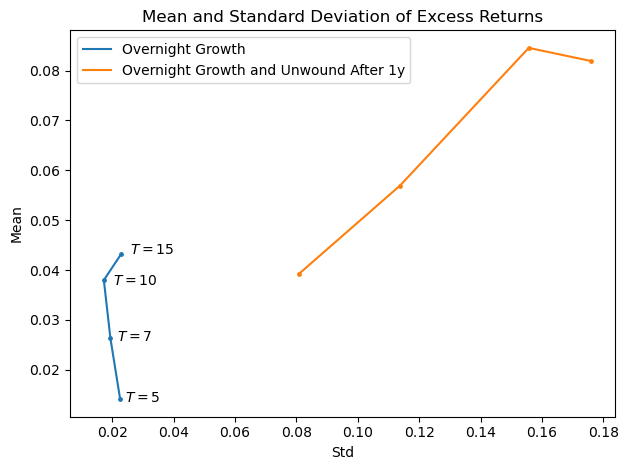

In [37]:
stds3 = np.array([np.std(returns[ts3[i] > start_time], ddof=1) for i, returns in enumerate(excess_returns3)])
means3 = np.array([np.mean(returns[ts3[i] > start_time]) for i, returns in enumerate(excess_returns3)])

plt.plot(stds2, means2, label = "Overnight Growth")
plt.scatter(stds2, means2, s=6)
plt.plot(stds3, means3, label = "Overnight Growth and Unwound After 1y")
plt.scatter(stds3, means3, s=6)
plt.legend()
x_min, x_max = plt.xlim()
plt.xlim(x_min-0.003, x_max)
plt.ylabel('Mean')
plt.xlabel('Std')
plt.annotate(rf'$T=5$', xy=(stds2[0]+0.0015, means2[0]-0.0005))
plt.annotate(rf'$T=7$', xy=(stds2[1]+0.002, means2[1]-0.0005))
plt.annotate(rf'$T=10$', xy=(stds2[2]+0.003, means2[2]-0.001))
plt.annotate(rf'$T=15$', xy=(stds2[3]+0.003, means2[3]))
plt.title('Mean and Standard Deviation of Excess Returns')
plt.tight_layout()
#plt.savefig('unwound_mean_stds.pdf', format='pdf')

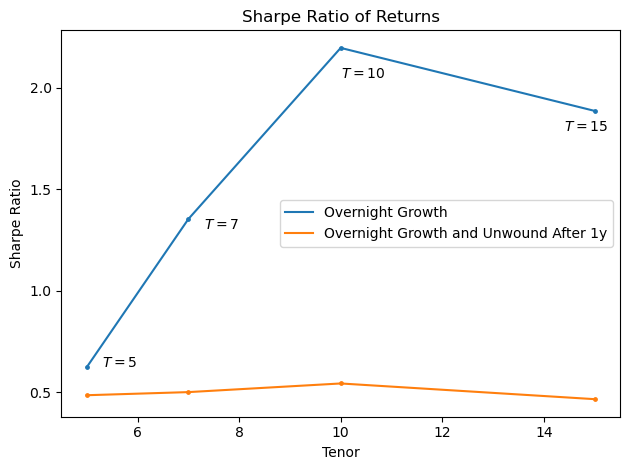

In [38]:
sharpes3 = means3/stds3

plt.plot(tenors, sharpes2, label = "Overnight Growth")
plt.scatter(tenors, sharpes2, s=6)
plt.plot(tenors, sharpes3, label = "Overnight Growth and Unwound After 1y")
plt.scatter(tenors, sharpes3, s=6)
plt.annotate(rf'$T=5$', xy=(tenors[0]+0.3, sharpes2[0]))
plt.annotate(rf'$T=7$', xy=(tenors[1]+0.3, sharpes2[1]-0.05))
plt.annotate(rf'$T=10$', xy=(tenors[2], sharpes2[2]-0.15))
plt.annotate(rf'$T=15$', xy=(tenors[3]-0.6, sharpes2[3]-0.1))
plt.legend()
plt.ylabel('Sharpe Ratio')
plt.xlabel('Tenor')
plt.title('Sharpe Ratio of Returns')
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.tight_layout()
#plt.savefig('unwound_sharpes.pdf', format='pdf')

## 10-2

In [39]:
def get_cash_margin_requirements2(date, maturity, runtime=None, margin=1.2):
    if runtime == None:
        runtime = maturity
    date_index = zero_bond_prices.index.get_loc(zero_bond_prices.loc[date].name)
    if date_index < maturity*252:
        return None
    long_bond_prices = np.array([interpolate_zero_bond_prices(date_index-i, i/252) for i in reversed(range((maturity-runtime)*252, 1+maturity*252))])
    short_bond_price_changes = []
    for j in reversed(range(maturity-runtime, maturity, 2)):
        short_bond_prices = np.array([interpolate_zero_bond_prices(date_index-i, (i-j*252)/252) for i in reversed(range(j*252, 1+(j+2)*252))])
        short_bond_price_changes.append((short_bond_prices[1:]-short_bond_prices[:-1])/short_bond_prices[:-1])
    start = time.time()
    short_bond_price_changes = np.concatenate(short_bond_price_changes)

    short_bond_prices = zero_bond_prices[maturity].iloc[date_index-maturity*252]*np.concatenate(([1], np.cumprod(1+short_bond_price_changes)))
    cash_margin = short_bond_prices*margin - long_bond_prices
    temp = np.nonzero(short_bond_prices > 1)
    if len(temp[0]) > 0:
        cash_margin = cash_margin[:temp[0][0]]
    cash_margin = cash_margin[~np.isnan(cash_margin)]
    if len(cash_margin) == 0:
        return 0
    return np.max(cash_margin)

In [42]:
two_year_shifted_date = shifted_dates['2_year_shifted_date']

def get_term_strategy_return_2y(tenor, overnight=True, start_index=0, runtime=None):
    if runtime is None:
        runtime = tenor
    long_shifted_date = shifted_dates[f'{tenor}_year_shifted_date'].dropna()
    excess_returns = []
    returns = []
    ts = []
    termination_times = []
    max_dds = []
    wealth_processes = []
    cash_levels = []
    count = 0
    margin_req = None

    for i in range(start_index, len(long_shifted_date)):
        start = long_shifted_date.index[i]
        next_date = start
        current = start
        end = long_shifted_date.iat[i]
        if end is pd.NaT or np.isnan(zero_bond_prices.at[start, tenor]):
            continue
        if count % 22 == 0:
            margin_req = get_cash_margin_requirements2(start, tenor, runtime, margin)
            if margin_req != None:
                margin_req *= margin_multiplier
                #print('Margin Update: ', zero_bond_prices.index[i], margin_req)
        if margin_req == None:
            continue
        #print(start)
        
        current_index = i
        short_units = zero_bond_prices.at[start, tenor]/zero_bond_prices.at[start, 2]
        if margin_req < zero_bond_prices.at[start, tenor]*0.2*margin_multiplier:
            margin_req = zero_bond_prices.at[start, tenor]*0.2*margin_multiplier
        #print(margin_req)
        broker_margin = zero_bond_prices.at[start, tenor]*0.2
        cash = margin_req
        cash_level = [cash]
        early_termination = False
        early_termination_payoff, early_termination_time = None, None
        max_wealth, current_wealth = margin_req, margin_req
        wealth_process = []
        max_dd = 0
        total_days = 0
        
        for j in range(2, runtime+1, 2):
            next_date = two_year_shifted_date.at[current]
            days_in_interval = zero_bond_prices.index.get_loc(zero_bond_prices.loc[next_date].name)-zero_bond_prices.index.get_loc(zero_bond_prices.loc[current].name)
            margin_check_dates = np.arange(margin_check_freq, days_in_interval, margin_check_freq)
            year_fractions = (days_in_interval-margin_check_dates)/(days_in_interval/2)
            year_fraction1, year_fraction2 = year_fractions[year_fractions >= 1], year_fractions[year_fractions < 1]
            margin_check_dates1 = margin_check_dates[margin_check_dates <= days_in_interval/2]
            margin_check_dates2 = margin_check_dates[margin_check_dates > days_in_interval/2]
            short_prices = np.concatenate((vector_interpolate_zero_bond_prices(current_index+margin_check_dates1, year_fraction1), \
                                           vector_interpolate_zero_bond_prices(current_index+margin_check_dates2, year_fraction2)))
            long_prices = np.concatenate((vector_interpolate_zero_bond_prices(current_index+margin_check_dates1, tenor-j+year_fraction1), \
                                          vector_interpolate_zero_bond_prices(current_index+margin_check_dates2, tenor-j+year_fraction2)))
            overnight_mult = overnight_ratio.iloc[current_index:current_index+days_in_interval]
            for k in range(len(margin_check_dates)):
                short_price = short_prices[k]
                long_price = long_prices[k]
                wealth = cash + long_price - short_units*short_price
                wealth_process.append(wealth)
                if overnight:
                    free_cash = cash-broker_margin
                    for l in range(margin_check_freq):
                        free_cash *= overnight_mult.iat[margin_check_freq*k+l]
                    cash = broker_margin + free_cash
                cash_level.append(cash)
                if wealth > max_wealth:
                    max_wealth = wealth
                else:
                    max_dd = max(max_dd, (max_wealth-wealth)/max_wealth)
                broker_margin = short_price*margin*short_units-long_price
                if broker_margin > cash or short_units >= 1:
                    early_termination = True
                    early_termination_wealth = long_price - short_price*short_units + cash
                    early_termination_time = j-2+2*margin_check_dates[k]/days_in_interval
                    total_days += margin_check_dates[k]
                    break
            
            if early_termination:
                break
            total_days += days_in_interval
            if j == tenor:
                long_price = 1
            else:
                long_price = zero_bond_prices.loc[next_date, tenor-j]
            if overnight:
                free_cash = cash-broker_margin
                for l in range(days_in_interval-margin_check_dates[-1]):
                    free_cash *= overnight_mult.iat[margin_check_freq*len(margin_check_dates)+l]
                cash = broker_margin + free_cash
            cash_level.append(cash)
            if j == runtime:
                break
            if margin*short_units-long_price > cash or short_units/zero_bond_prices.at[next_date, 2] >= 1:
                early_termination = True
                early_termination_wealth = long_price - short_units + cash
                early_termination_time = j
            else:
                short_units /= zero_bond_prices.at[next_date, 2]
            broker_margin = margin*short_units-long_price
            current = next_date
            current_index += days_in_interval
            
        ts.append(start)
        max_dds.append(max_dd)
        wealth_processes.append(wealth_process)
        cash_levels.append(cash_level)
        if early_termination:
            rf = np.prod(overnight_ratio.iloc[i:i+total_days])**(1/early_termination_time)
            #print('Rf: ', rf)
            #print(f'Early exercise at time {np.round(early_termination_time, 2)} with return = ', (early_termination_wealth/margin_req)**(1/early_termination_time)-1)
            #print(margin_req, early_termination_wealth)
            returns.append((early_termination_wealth/margin_req)**(1/early_termination_time)-1)
            excess_returns.append((early_termination_wealth/margin_req)**(1/early_termination_time)-rf)
            termination_times.append(early_termination_time)
        else:
            rf = np.prod(overnight_ratio.iloc[i:i+total_days])**(1/runtime)
            #print('Rf: ', rf)
            #print('Maturity with return = ', ((1-short_units+cash)/margin_req)**(1/tenor)-1)
            #print(margin_req, short_units, 1-short_units+cash)
            returns.append(((long_price-short_units+cash)/margin_req)**(1/runtime)-1)
            excess_returns.append(((long_price-short_units+cash)/margin_req)**(1/runtime)-rf)
            termination_times.append(runtime)
        #print('-'*10)
        count += 1
    return np.array(ts), np.array(returns), np.array(excess_returns), np.array(termination_times), np.array(max_dds), wealth_processes, cash_levels

In [43]:
ts4, returns4, excess_returns4, termination_times4, max_drawdown4, wealth4, cash4 = [], [], [], [], [], [], []

start = time.time()

t4, ret4, ex_returns4, t_end4, max_dds4, wealth_processes4, c4 = get_term_strategy_return_2y(10, overnight=True)
ts4.append(t4)
returns4.append(ret4)
excess_returns4.append(ex_returns4)
termination_times4.append(t_end4)
max_drawdown4.append(max_dds4)
wealth4.append(wealth_processes4)
cash4.append(c4)

print(time.time()-start)

92.46565747261047


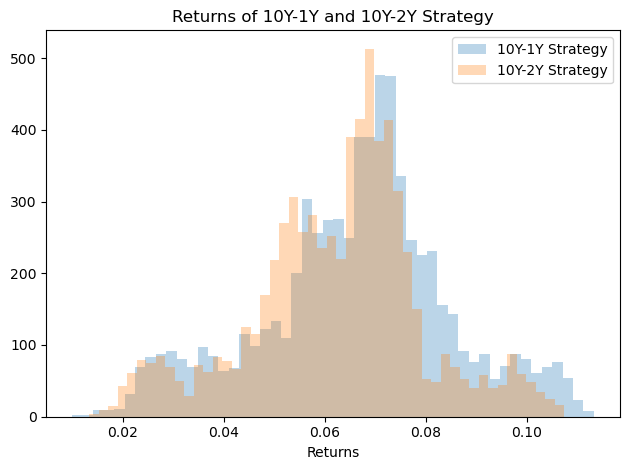

In [44]:
plt.hist(returns2[2][ts2[2] > start_time], bins=50, alpha=0.3, label='10Y-1Y Strategy')
plt.hist(returns4[0][ts4[0] > start_time], bins=50, alpha=0.3, label='10Y-2Y Strategy')
plt.title('Returns of 10Y-1Y and 10Y-2Y Strategy')
plt.xlabel('Returns')
plt.legend()
plt.tight_layout()
#plt.savefig('1y_vs_2y_hist.pdf', format='pdf')

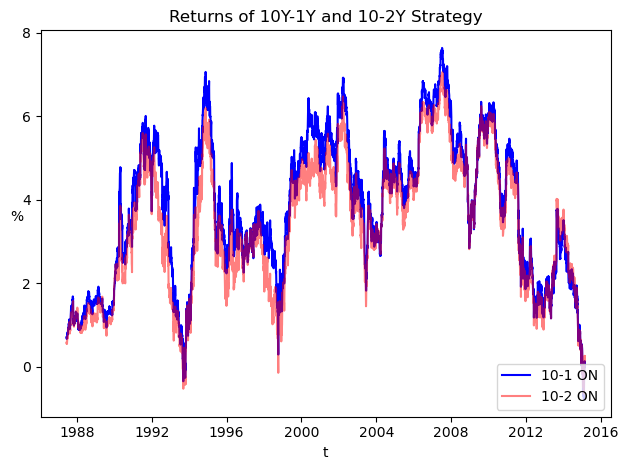

In [45]:
plt.plot(ts2[2][ts2[2] > start_time], 100*excess_returns2[2][ts2[2] > start_time], c='b')
plt.plot(ts4[0][ts4[0] > start_time], 100*excess_returns4[0][ts4[0] > start_time], c='r', alpha=0.5)
plt.title(f'Returns of 10Y-1Y and 10-2Y Strategy')
plt.ylabel('%', rotation=0)
plt.xlabel('t')
plt.legend(['10-1 ON', '10-2 ON'], loc=4)
plt.tight_layout()
#plt.savefig('1y_vs_2y_plot.pdf', format='pdf')

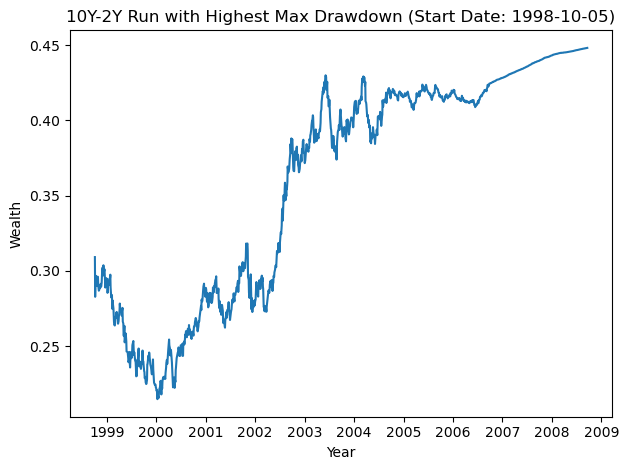

In [46]:
worst_dd_time = ts4[0][6755]
worst_dd_time_index = zero_bond_prices.index.get_loc(worst_dd_time)

plt.plot(zero_bond_prices.index[worst_dd_time_index:worst_dd_time_index+2*len(wealth4[0][6755]):2], wealth4[0][6755])
plt.title('10Y-2Y Run with Highest Max Drawdown (Start Date: ' + worst_dd_time.strftime('%Y-%m-%d') + ')')
plt.ylabel('Wealth')
plt.xlabel('Year')
plt.tight_layout()
#plt.savefig('10y2y_drawdown_wealth.pdf', format='pdf')

In [47]:
excess = excess_returns4[0][ts4[0] > start_time]
print('Mean of 10Y-1Y vs 10Y-2Y:', means2[2], np.mean(excess))
print('Std of 10Y-1Y vs 10Y-2Y:', stds2[2], np.std(excess, ddof=1))
print('Sharpe of 10Y-1Y vs 10Y-2Y:', sharpes2[2], np.mean(excess)/np.std(excess, ddof=1))

Mean of 10Y-1Y vs 10Y-2Y: 0.03797168198628403 0.03392768313142422
Std of 10Y-1Y vs 10Y-2Y: 0.01728739232448739 0.016200848998754132
Sharpe of 10Y-1Y vs 10Y-2Y: 2.1964956468592187 2.094191676870348
